In [1]:
#export
"""
This is for all short utilities that converts from 1 data type to another. They
might feel they have different styles, as :class:`toFloat` converts object iterator to
float iterator, while :class:`toImg` converts single image url to single PIL image,
whereas :class:`toSum` converts float iterator into a single float value.

The general convention is, if the intended operation sounds simple (convert to floats,
strings, types, ...), then most likely it will convert iterator to iterator, as you
can always use the function directly if you only want to apply it on 1 object.

If it sounds complicated (convert to PIL image, tensor, ...) then most likely it will
convert object to object. Lastly, there are some that just feels right to input
an iterator and output a single object (like getting max, min, std, mean values)."""
__all__ = ["toNdArray", "toTensor", "toRange", "toList",
           "toSum", "toProd", "toAvg", "toMean", "toStd", "toMedian", "toMax", "toMin", "toArgmin", "toArgmax",
           "toImg", "toRgb", "toRgba", "toGray", "toDict",
           "toFloat", "toInt", "toRoman", "toBytes", "toDataUri", "toAnchor", "toHtml",
           "toAscii", "toHash", "toCsv", "toYaml", "Audio", "toAudio", "toUnix", "toIso", "toYMD", "toLinks",
           "toMovingAvg", "toCm", "Pdf", "toPdf", "toDist", "toAngle", "idxsToNdArray", "toFileType", "toQr", "toExcel", "toMdTable"]
import re, k1lib, math, os, numpy as np, io, json, base64, unicodedata, inspect, time, functools
from k1lib.cli.init import BaseCli, T, yieldT; import k1lib.cli as cli, k1lib.cli.init as init
from k1lib.cli.typehint import *; mpl = k1lib.dep.mpl; plt = k1lib.dep.plt; yaml = k1lib.dep.yaml; pd = k1lib.dep.pd; cm = k1lib.dep.cm; cv2 = k1lib.dep.cv2
from collections import deque, defaultdict, OrderedDict; from typing import Iterator, Any, List, Set, Tuple, Dict, Callable, Union
settings = k1lib.settings.cli; imgkit = k1lib.dep("imgkit", url="https://github.com/csquared/IMGKit")
try: import PIL; import PIL.Image; hasPIL = True
except: hasPIL = False
try: import torch; hasTorch = True
except: torch = k1lib.dep.torch; hasTorch = False
try: import rdkit; hasRdkit = True
except: hasRdkit = False
try: import graphviz; hasGraphviz = True
except: hasGraphviz = False
try: import plotly; import plotly.express as px; hasPlotly = True
except: hasPlotly = False
try: import pandas as pd; pd.core; hasPandas = True
except: hasPandas = False

In [2]:
cli.init.patchNumpy()

In [3]:
#export
class toNdArray(BaseCli):
    blurb="Converts several data types to numpy.ndarray"
    def __init__(self, dtype=None):
        """Converts generator/several data types to :class:`numpy.ndarray`. Essentially
``np.array(list(it))``. Can convert PIL Image. Example::

    # returns array([0., 1., 2.])
    range(3) | toNdArray()
    # returns array([0., 1., 2.], dtype=float32)
    range(3) | toNdArray(np.float32)
"""
        self.dtype = dtype
    def _all_array_opt(self, it, level): return it.detach().cpu().numpy().asdtype(self.dtype) if hasTorch and isinstance(it, torch.Tensor) else it
    def __ror__(self, it):
        if hasattr(it, "_toNdArray"):
            args = inspect.getfullargspec(it._toNdArray).args[1:]; n = len(args)
            s = set(["dtype"]); weirdArgs = [a for a in args if a not in s]
            if len(weirdArgs) > 0: raise Exception(f"Custom datatype `{type(it)}` has ._toNdArray() method, which expects only `dtype` arguments, but detected these arguments instead: {weirdArgs}. Please fix `{type(it)}`")
            return it._toNdArray() if n == 0 else it._toNdArray(self.dtype)
        if hasPIL and isinstance(it, PIL.Image.Image):
            mode_to_nptype = {'I': np.int32, 'I;16': np.int16, 'F': np.float32}
            img = np.array(it, mode_to_nptype.get(it.mode, np.uint8), copy=True)
            if it.mode == '1': img = 255 * img
            img = img.reshape((it.size[1], it.size[0], len(it.getbands())))
            it = img.transpose((2, 0, 1))
        if hasPandas and isinstance(it, pd.core.arraylike.OpsMixin): it = it.to_numpy()
        if hasTorch and isinstance(it, torch.Tensor): it = it.numpy()
        if not isinstance(it, np.ndarray): it = np.array(list(it))
        return it.astype(self.dtype) if self.dtype else it

In [4]:
assert all(range(3) | toNdArray() == np.array([0, 1, 2]))
class A:
    def _toNdArray(self): return 3
assert A() | toNdArray() == 3
class A:
    def _toNdArray(self, dtype): return dtype
assert A() | toNdArray(4) == 4
df1 = pd.DataFrame({"A": [1.0,2,3,4], "B": pd.Timestamp("20130102"), "C": pd.Series(1, index=list(range(4)), dtype="float32"), "D": np.array([3] * 4, dtype="int32"), "E": pd.Categorical(["test", "train", "test", "train"]), "F": "foo",})
assert df1 | toNdArray() | cli.shape() == (4, 6)
assert (df1["A"] | toNdArray() == np.array([1,2,3,4.])).all()

In [5]:
#export
class toTensor(BaseCli):
    blurb="Converts several data types to torch.Tensor"
    def __init__(self, dtype=None):
        """Converts generator to :class:`torch.Tensor`. Essentially
``torch.tensor(list(it))``. Default dtype is float32. Can convert PIL Image. Example::

    # returns tensor([0., 1., 2.], dtype=torch.float64)
    range(3) | toTensor(torch.float64)
"""
        self.dtype = dtype or torch.float32
    def _all_array_opt(self, it, level): return torch.tensor(it, dtype=self.dtype)
    def __ror__(self, it:Iterator[float]) -> "torch.Tensor":
        if hasattr(it, "_toTensor"):
            args = inspect.getfullargspec(it._toTensor).args[1:]; n = len(args)
            s = set(["dtype"]); weirdArgs = [a for a in args if a not in s]
            if len(weirdArgs) > 0: raise Exception(f"Custom datatype `{type(it)}` has ._toTensor() method, which expects only `dtype` arguments, but detected these arguments instead: {weirdArgs}. Please fix `{type(it)}`")
            return it._toTensor() if n == 0 else it._toTensor(self.dtype)
        if not isinstance(it, torch.Tensor): it = torch.from_numpy(it | toNdArray())
        return it.to(self.dtype)

In [ ]:
assert (range(3) | toTensor(torch.float64)).dtype == torch.float64
class A:
    def _toTensor(self): return 3
assert A() | toTensor() == 3
class A:
    def _toTensor(self, dtype): return dtype
assert A() | toTensor(4) == 4

In [8]:
#export
class toList(BaseCli): # this still exists cause some LLVM optimizations are done on this, and too tired to change that at the moment
    def __init__(self):
        """Converts generator to list. 
Example::

    # returns [0, 1, 2, 3, 4]
    range(5) | toList()
    # returns [0, 1, 2, 3, 4]
    range(5) | aS(list)

So this cli is sort of outdated. It still works fine, nothing wrong
with it, but just do ``aS(list)`` instead. It's not removed to
avoid breaking old projects."""
        super().__init__()
    def _all_array_opt(self, it, level): return it
    def _typehint(self, inp):
        if isinstance(inp, tListIterSet): return tList(inp.child)
        if isinstance(inp, tCollection): return inp
        return tList(tAny())
    def __ror__(self, it:Iterator[Any]) -> List[Any]: return list(init.dfGuard(it))
    def _jsF(self, meta): fIdx = init._jsFAuto(); dataIdx = init._jsDAuto(); return f"{fIdx} = ({dataIdx}) => {dataIdx}", fIdx
    def _pyF(self, expr, **kw): return "", "", f"list({expr})", {}
def _toRange(it):
    for i, _ in enumerate(it): yield i
class toRange(BaseCli):
    blurb="Returns iter(range(len(it))), but incrementally"
    def __init__(self):
        """Returns iter(range(len(it))), effectively.
Example::

    # returns [0, 1, 2]
    [3, 2, 5] | toRange() | deref()"""
        super().__init__()
    def __ror__(self, it:Iterator[Any]) -> Iterator[int]:
        try: return range(len(it))
        except: return _toRange(it)
    def _jsF(self, meta):
        fIdx = init._jsFAuto(); dataIdx = init._jsDAuto()
        return f"{fIdx} = ({dataIdx}) => {dataIdx}.toRange()", fIdx
    def _pyF(self, expr, **kw): i = init._pyFAuto(); e = init._pyFAuto(); return "", "", f"({i} for {i},{e} in enumerate({expr}))", {}
tOpt.addPass(lambda cs, ts, _: [cs[0]], [toRange, toRange])

In [14]:
assert [2, 3.5, "ah", np.random.randn(2, 3)] | tCheck() | cli.apply(type) | cli.deref() == [int, float, str, np.ndarray]
assert range(10, 20) | tCheck() | toRange() == range(0, 10)
assert [3, 2, 5] | toRange() | cli.deref() == [0, 1, 2]

In [29]:
a = cli.toPyFunc() | toList();  assert range(5) | a == [0, 1, 2, 3, 4]; print([a.program])
a = cli.toPyFunc() | toRange(); assert list(range(5) | a) == [0, 1, 2, 3, 4]; print([a.program])

['\n\ndef _pyF_235_37(_pyF_235_36):return list(_pyF_235_36)']
['\n\ndef _pyF_235_41(_pyF_235_38):return (_pyF_235_39 for _pyF_235_39,_pyF_235_40 in enumerate(_pyF_235_38))']


In [41]:
#export
settings.add("arrayTypes", (torch.Tensor, np.ndarray) if hasTorch else (np.ndarray,), "default array types used to accelerate clis")
def genericTypeHint(inp):
    if isinstance(inp, tListIterSet): return inp.child
    if isinstance(inp, tCollection): return inp.children[0]
    if isinstance(inp, tArrayTypes): return inp.child
    return tAny()
class toSum(BaseCli):
    blurb="Calculates the sum of a list of numbers"
    def __init__(self):
        """Calculates the sum of list of numbers. Can pipe in :class:`torch.Tensor` or :class:`numpy.ndarray`.
Example::

    range(10)                | toSum()                 # returns 45
    np.random.randn(2, 3, 4) | toSum().all() | shape() # returns (2,)
"""
        super().__init__()
    def _all_array_opt(self, it, level):
        bm = np if isinstance(it, np.ndarray) else (torch if hasTorch and isinstance(it, torch.Tensor) else None)
        return NotImplemented if bm is None else bm.sum(it, tuple(range(level, len(it.shape))))
    def _typehint(self, inp): return genericTypeHint(inp)
    def __ror__(self, it:Iterator[float]):
        if isinstance(it, settings.arrayTypes) or (hasPandas and isinstance(it, pd.Series)): return it.sum()
        return sum(init.dfGuard(it))
    def _jsF(self, meta): fIdx = init._jsFAuto(); dataIdx = init._jsDAuto(); return f"{fIdx} = ({dataIdx}) => {dataIdx}.toSum()", fIdx
    def _pyF(self, expr): return "", "", f"sum({expr})", {}
class toProd(BaseCli):
    blurb="Calculates the product of a list of numbers"
    def __init__(self):
        """Calculates the product of a list of numbers. Can pipe in :class:`torch.Tensor` or :class:`numpy.ndarray`.
Example::

    range(1,10)              | toProd()                 # returns 362880
    np.random.randn(2, 3, 4) | toProd().all() | shape() # returns (2,)
"""
        super().__init__()
    def _all_array_opt(self, it, level):
        if isinstance(it, np.ndarray): return np.prod(it, tuple(range(level, len(it.shape))))
        elif hasTorch and isinstance(it, torch.Tensor):
            for i in range(level, len(it.shape)): it = torch.prod(it, level)
            return it
        return NotImplemented
    def _typehint(self, inp): return genericTypeHint(inp)
    def __ror__(self, it):
        if isinstance(it, settings.arrayTypes) or (hasPandas and isinstance(it, pd.Series)): return it.prod()
        else: return math.prod(init.dfGuard(it))
    def _jsF(self, meta): fIdx = init._jsFAuto(); dataIdx = init._jsDAuto(); return f"{fIdx} = ({dataIdx}) => {dataIdx}.toProd()", fIdx
    def _pyF(self, expr, **kw): return "import math", "", f"math.prod({expr})", {}
class toAvg(BaseCli):
    blurb="Calculates the average of a list of numbers"
    def __init__(self):
        """Calculates average of list of numbers. Can pipe in :class:`torch.Tensor` or :class:`numpy.ndarray`.
Example::

    range(10)                | toAvg()                 # returns 4.5
    []                       | toAvg()                 # returns nan
    np.random.randn(2, 3, 4) | toAvg().all() | shape() # returns (2,)
"""
        super().__init__()
    def _all_array_opt(self, it, level):
        bm = np if isinstance(it, np.ndarray) else (torch if hasTorch and isinstance(it, torch.Tensor) else None)
        return NotImplemented if bm is None else bm.mean(it, tuple(range(level, len(it.shape))))
    def _typehint(self, inp):
        i = None
        if isinstance(inp, tListIterSet): i = inp.child
        if isinstance(inp, tCollection): i = inp.children[0]
        if isinstance(inp, tArrayTypes): i = inp.child
        if i is not None: return float if i == int else i
        return tAny()
    def __ror__(self, it:Iterator[float]):
        if isinstance(it, settings.arrayTypes) or (hasPandas and isinstance(it, pd.Series)): return it.mean()
        s = 0; i = -1
        for i, v in enumerate(init.dfGuard(it)): s += v
        i += 1
        if not k1lib.settings.cli.strict and i == 0: return float("nan")
        return s / i
    def _jsF(self, meta):
        fIdx = init._jsFAuto(); dataIdx = init._jsDAuto()
        return f"{fIdx} = ({dataIdx}) => {dataIdx}.toAvg()", fIdx
    def _pyF(self, expr, **kw): funcN = init._pyFAuto(); return "", f"""
def {funcN}(x):
    n = len(x)
    if n == 0: return float("nan")
    return sum(x)/n""", f"{funcN}({expr})", {}
if hasTorch:
    torchVer = int(torch.__version__.split(".")[0])
    if torchVer >= 2:
        def torchStd(it, ddof, dim=None): return torch.std(it, dim, correction=ddof)
    else:
        def torchStd(it, ddof, dim=None):
            if ddof == 0: return torch.std(it, dim, unbiased=False)
            if ddof == 1: return torch.std(it, dim, unbiased=True)
            raise Exception(f"Please install PyTorch 2, as version 1 don't support correction factor of {ddof}")
else:
    def torchStd(it, ddof): raise Exception("PyTorch not installed")
class toStd(BaseCli):
    blurb="Calculates the standard deviation of a list of numbers"
    def __init__(self, ddof:int=0):
        """Calculates standard deviation of list of numbers. Can pipe in :class:`torch.Tensor`
or :class:`numpy.ndarray` to be faster. Example::

    range(10)                | toStd()                 # returns 2.8722813232690143
    []                       | toStd()                 # returns nan
    np.random.randn(2, 3, 4) | toStd().all() | shape() # returns (2,)

:param ddof: "delta degree of freedom". The divisor used in calculations is ``N - ddof``"""
        self.ddof = ddof
    def _all_array_opt(self, it, level):
        n = len(it.shape); ddof = self.ddof; dim = tuple(range(level, n))
        if isinstance(it, np.ndarray): return np.std(it, ddof=ddof, axis=dim)
        elif hasTorch and isinstance(it, torch.Tensor): return torchStd(it, ddof, dim)
        return NotImplemented
    def __ror__(self, it):
        ddof = self.ddof
        if hasPandas and isinstance(it, pd.Series): return it.std(ddof=self.ddof)
        if hasPandas and isinstance(it, pd.DataFrame): it = init.dfGuard(it)
        if isinstance(it, settings.arrayTypes):
            if isinstance(it, np.ndarray): return np.std(it, ddof=ddof)
            elif hasTorch and isinstance(it, torch.Tensor): return torchStd(it, ddof)
        return np.std(np.array(list(it)), ddof=ddof)
    def _jsF(self, meta):
        fIdx = init._jsFAuto(); dataIdx = init._jsDAuto()
        return f"{fIdx} = ({dataIdx}) => {dataIdx}.toStd()", fIdx
toMean = toAvg

In [10]:
assert range(10) | tCheck() | toSum() == 45
assert range(1,10) | tCheck() | toProd() == 362880
assert range(10) | tCheck() | toAvg() == 4.5
assert id([] | toAvg()) == id(float("nan"))
assert np.linspace(2, 3) | toAvg() == 2.5
assert 2.8 < (range(10) | toStd()) < 2.9
a = np.random.randn(2, 3, 4); ta = torch.tensor(a)
assert a  | toSum() .all()  | cli.op().shape == (2,);   assert a  | toProd().all()  | cli.op().shape == (2,)
assert a  | toAvg() .all()  | cli.op().shape == (2,);   assert a  | toStd() .all()  | cli.op().shape == (2,)
assert ta | toSum() .all()  | cli.op().shape == (2,);   assert ta | toProd().all()  | cli.op().shape == (2,)
assert ta | toAvg() .all()  | cli.op().shape == (2,);   assert ta | toStd() .all()  | cli.op().shape == (2,)
assert a  | toSum() .all(2) | cli.op().shape == (2, 3); assert a  | toProd().all(2) | cli.op().shape == (2, 3)
assert a  | toAvg() .all(2) | cli.op().shape == (2, 3); assert a  | toStd() .all(2) | cli.op().shape == (2, 3)
assert ta | toSum() .all(2) | cli.op().shape == (2, 3); assert ta | toProd().all(2) | cli.op().shape == (2, 3)
assert ta | toAvg() .all(2) | cli.op().shape == (2, 3); assert ta | toStd() .all(2) | cli.op().shape == (2, 3)
assert df1["A"] | toStd() == 1.118033988749895

In [44]:
a = cli.toPyFunc() | toSum();  assert range(5) | a == 10; print([a.program])
a = cli.toPyFunc() | toProd();  assert range(1,5) | a == 24; print([a.program])
a = cli.toPyFunc() | toAvg(); range(5) | a == 2; print([a.program])

['\n\ndef _pyF_235_68(_pyF_235_67):return sum(_pyF_235_67)']
['import math\n\ndef _pyF_235_70(_pyF_235_69):return math.prod(_pyF_235_69)']
['\ndef _pyF_235_72(x):\n    n = len(x)\n    if n == 0: return float("nan")\n    return sum(x)/n\ndef _pyF_235_73(_pyF_235_71):return _pyF_235_72(_pyF_235_71)']


In [45]:
init.ArrayOptException

k1lib.cli.init.ArrayOptException

In [46]:
#export
class toMedian(BaseCli):
    blurb="Calculates the median of a list of numbers"
    def __init__(self, percentile=50):
        """Calculates the median of a list of numbers.
Example::

    range(10)                | toMedian()                  # returns 4.5
    [1, 2, 4]                | toMedian()                  # returns 2.0
    np.random.randn(3, 4, 5) | toMedian().all(1) | shape() # returns (3,)
"""
        self.percentile = percentile
    def _all_array_opt(self, it, level):
        q = self.percentile; n = len(it.shape)
        if n == level: return it
        if n < level: raise init.ArrayOptException(f"You're trying to do `np.random.randn({', '.join(it.shape)}) | toMedian().all({level})` which does not make sense, as the array's dimension is less than the .all() dimension")
        it = it | cli.joinSt(n-level-1).all(level)
        if q == 50:
            if isinstance(it, np.ndarray): return np.median(it, level)
            if hasTorch and isinstance(it, torch.Tensor): return torch.median(it, level).values
        else:
            if isinstance(it, np.ndarray): return np.percentile(it, q, level)
            if hasTorch and isinstance(it, torch.Tensor): return torch.tensor(np.percentile(it.cpu().numpy(), q, level), dtype=it.dtype, device=it.device)
        return NotImplemented
    def __ror__(self, it):
        q = self.percentile
        if hasPandas and isinstance(it, pd.core.arraylike.OpsMixin): it = it.to_numpy()
        if isinstance(it, np.ndarray): return np.median(it) if q == 50 else np.percentile(it, q)
        if hasTorch and isinstance(it, torch.Tensor): return torch.median(it) if q == 50 else torch.tensor(np.percentile(it.cpu().numpy(), q), dtype=it.dtype, device=it.device)
        try: return np.percentile(it, q)
        except: return np.percentile(it | cli.deref(), q)
    def _pyF(self, expr, **kw):
        funcN = init._pyFAuto()
        return "", f"def {funcN}(x): return sorted(x)[{self.percentile}*len(x)//100]", f"{funcN}({expr})", {}

In [13]:
assert [1, 2, 4] | toMedian() == 2.0
a = np.random.randn(3, 4, 5, 6)
assert a | toMedian().all(1) | cli.shape() == (3,)
assert a | toMedian().all(2) | cli.shape() == (3,4)
assert a | toMedian().all(3) | cli.shape() == (3,4,5)
assert (a | toMedian().all(4) == a).all()
a = torch.randn(3, 4, 5, 6)
assert a | toMedian().all(1) | cli.shape() == (3,)
assert a | toMedian().all(2) | cli.shape() == (3,4)
assert a | toMedian().all(3) | cli.shape() == (3,4,5)
assert (a | toMedian().all(4) == a).all()
assert a | toMedian(30).all(2) | cli.shape() == (3, 4)
assert df1["A"] | toMedian() == 2.5

In [60]:
b = list(range(10) | cli.randomize())
a = cli.toPyFunc() | toMedian(); assert b | a == 5; print([a.program])
a = cli.toPyFunc() | toMedian(40); assert b | a == 4; print([a.program])

['\ndef _pyF_235_102(x): return sorted(x)[50*len(x)//100]\ndef _pyF_235_103(_pyF_235_101):return _pyF_235_102(_pyF_235_101)']
['\ndef _pyF_235_105(x): return sorted(x)[40*len(x)//100]\ndef _pyF_235_106(_pyF_235_104):return _pyF_235_105(_pyF_235_104)']


In [14]:
#export
class toMax(BaseCli):
    blurb="Calculates the max value of a list of numbers"
    def __init__(self, default=None):
        """Calculates the max of a bunch of numbers. Can pipe in :class:`torch.Tensor` or :class:`numpy.ndarray`.
Example::

    [2, 5, 6, 1, 2]          | toMax()                 # returns 6
    np.random.randn(2, 3, 4) | toMax().all() | shape() # returns (2,)
"""
        super().__init__(); self.default = default
    def _all_array_opt(self, it, level):
        if isinstance(it, np.ndarray): return np.max(it, tuple(range(level, len(it.shape)))); self.default = default
        elif hasTorch and isinstance(it, torch.Tensor):
            for i in range(level, len(it.shape)): it = torch.max(it, level)[0]
            return it
        return NotImplemented
    def __ror__(self, it:Iterator[float]) -> float:
        if isinstance(it, settings.arrayTypes) or (hasPandas and isinstance(it, pd.Series)): return it.max()
        if self.default is None: return max(it)
        try: return max(it)
        except ValueError: return self.default
    def _jsF(self, meta): fIdx = init._jsFAuto(); dataIdx = init._jsDAuto(); return f"{fIdx} = ({dataIdx}) => {dataIdx}.toMax()", fIdx
    def _pyF(self, expr, **kw): return "", "", f"max({expr})", {}
class toMin(BaseCli):
    blurb="Calculates the min value of a list of numbers"
    def __init__(self):
        """Calculates the min of a bunch of numbers. Can pipe in :class:`torch.Tensor` or :class:`numpy.ndarray`.
Example::

    [2, 5, 6, 1, 2]          | toMin()                 # returns 1
    np.random.randn(2, 3, 4) | toMin().all() | shape() # returns (2,)
"""
        super().__init__()
    def _all_array_opt(self, it, level):
        if isinstance(it, np.ndarray): return np.min(it, tuple(range(level, len(it.shape))))
        elif hasTorch and isinstance(it, torch.Tensor):
            for i in range(level, len(it.shape)): it = torch.min(it, level)[0]
            return it
        return NotImplemented
    def __ror__(self, it:Iterator[float]) -> float:
        if isinstance(it, settings.arrayTypes) or (hasPandas and isinstance(it, pd.Series)): return it.min()
        return min(it)
    def _jsF(self, meta): fIdx = init._jsFAuto(); dataIdx = init._jsDAuto(); return f"{fIdx} = ({dataIdx}) => {dataIdx}.toMin()", fIdx
    def _pyF(self, expr, **kw): return "", "", f"min({expr})", {}

In [15]:
assert [2, 5, 6, 1, 2] | toMax() == 6
assert [2, 5, 6, 1, 2] | toMin() == 1
a = np.random.randn(2, 3, 4); ta = torch.tensor(a)
assert a | toMax().all() | cli.shape() == (2,)
assert a  | toMax().all(2) | cli.op().shape == (2, 3)
assert ta | toMax().all(2) | cli.op().shape == (2, 3)
assert a  | toMin().all(2) | cli.op().shape == (2, 3)
assert ta | toMin().all(2) | cli.op().shape == (2, 3)
assert df1["A"] | toMax() == 4.0

In [16]:
#export
class toArgmin(BaseCli):
    blurb="Grabs the min value's index"
    def __init__(self):
        """Get the input iterator's index of the min value.
Example::

    [2, 3, 4, 1, 5]          | toArgmin()                 # returns 3
    np.random.randn(3, 4, 5) | toArgmin().all() | shape() # returns (3,)
"""
        pass
    def _all_array_opt(self, it, level):
        n = len(it.shape)
        if n < level: raise Exception(f"You're trying to do `np.random.randn({', '.join(it.shape)}) | toArgmin().all({level})` which does not make sense, as the array's dimension is less than the .all() dimension")
        it = it | cli.joinSt(n-level-1).all(level); return it.argmin(level)
    def __ror__(self, it):
        if isinstance(it, k1lib.settings.cli.arrayTypes): return it.argmin().item()
        if hasPandas and isinstance(it, pd.Series): return it.argmin().item()
        try: len(it); return np.array(it).argmin().item()
        except: return np.array(it | cli.deref()).argmin().item()
class toArgmax(BaseCli):
    blurb="Grabs the max value's index"
    def __init__(self):
        """Get the input iterator's index of the max value.
Example::

    [2, 3, 4, 1, 5]          | toArgmax()                 # returns 4
    np.random.randn(3, 4, 5) | toArgmax().all() | shape() # returns (3,)
"""
        pass
    def _all_array_opt(self, it, level):
        n = len(it.shape)
        if n < level: raise Exception(f"You're trying to do `np.random.randn({', '.join(it.shape)}) | toArgmax().all({level})` which does not make sense, as the array's dimension is less than the .all() dimension")
        it = it | cli.joinSt(n-level-1).all(level); return it.argmax(level)
    def __ror__(self, it):
        if isinstance(it, k1lib.settings.cli.arrayTypes): return it.argmax().item()
        if hasPandas and isinstance(it, pd.Series): return it.argmax().item()
        try: len(it); return np.array(it).argmax().item()
        except: return np.array(it | cli.deref()).argmax().item()

In [17]:
assert [2, 3, 4, 1, 5] | toArgmin() == 3
assert [2, 3, 4, 1, 5] | toArgmax() == 4
a = np.random.randn(3, 4, 5, 6)
assert a | toArgmin().all(1) | cli.shape() == (3,)
assert a | toArgmin().all(2) | cli.shape() == (3,4)
assert a | toArgmin().all(3) | cli.shape() == (3,4,5)
assert a | toArgmin().all(4) | cli.shape() == (3,4,5,6)
a = torch.randn(3, 4, 5, 6)
assert a | toArgmax().all(1) | cli.shape() == (3,)
assert a | toArgmax().all(2) | cli.shape() == (3,4)
assert a | toArgmax().all(3) | cli.shape() == (3,4,5)
assert a | toArgmax().all(4) | cli.shape() == (3,4,5,6)
assert df1["A"] | toArgmax() == 3

In [18]:
#export
settings.add("font", None, "default font file. Best to use .ttf files, used by toImg()")
settings.add("chem", k1lib.Settings().add("imgSize", 200, "default image size used in toImg() when drawing rdkit molecules"), "chemistry-related settings")
class Svg(str):
    def _toImg(self, **kwargs):
        import tempfile; a = tempfile.NamedTemporaryFile()
        import cairosvg; cairosvg.svg2png(bytestring=f"{self}",write_to=a.name); im = a.name | toImg()
        return im
    def _repr_html_(self): return self
def cropToContentNp(ogIm, pad=10):
    dim = len(ogIm.shape); im = ogIm
    if dim > 2: im = im.mean(0)
    coords = np.argwhere(im.max()-im); x_min, y_min = coords.min(axis=0); x_max, y_max = coords.max(axis=0)
    return ogIm[x_min-pad:x_max+1+pad, y_min-pad:y_max+1+pad] if dim == 2 else ogIm[:,x_min-pad:x_max+1+pad, y_min-pad:y_max+1+pad]
def cropToContentPIL(im, pad=0):
    im = im | toNdArray(int) | cli.aS(cropToContentNp, pad)
    # return torch.from_numpy(im).permute(1, 2, 0) | toImg() if len(im.shape) > 2 else im | toImg()
    return np.transpose(im, (1, 2, 0)) | toImg() if len(im.shape) > 2 else im | toImg()
class toImg(BaseCli):
    blurb="Converts multiple data types into a PIL image"
    def __init__(self, closeFig=True, crop=True):
        """Converts multiple data types into a PIL image.
Example::

    ls(".") | toImg().all() | item()          # grabs first image in the current folder
    torch.randn(100, 200)           | toImg() # converts from tensor/array to image
    "abc.jpg" | toImg() | toBytes() | toImg() # grabs image, converts to byte stream, and converts back to image
    ["abc", "def"]                  | toImg() # converts paragraphs to image
    "c1ccc(C)cc1" | toMol()         | toImg() # converts SMILES string to molecule, then to image
    ["ab", "bc", "ca"] | (kgv.sketch() | kgv.edges()) | toHtml() | toImg() # sketches a graphviz plot, converts to svg then renders the svg as an image
    df | toHtml()                   | toImg() # converts pandas data frame to html, then render it to image
    "/dev/video0"                   | toImg() # reads an image from the 1st camera connected to the computer
    0                               | toImg() # same as above

You can also save a matplotlib figure by piping in a :class:`matplotlib.figure.Figure` object::

    x = np.linspace(0, 4)
    plt.plot(x, x**2)
    plt.gcf() | toImg()

.. note::
    
    If you are working with image tensors, which is typically have
    dimensions of (C, H, W), you have to permute it to PIL's (H, W, C)
    first before passing it into this cli.
    
    Also it's expected that
    your tensor image ranges from 0-255, and not 0-1. Make sure you
    renormalize it

:param closeFig: if input is a matplotlib figure, then closes the figure after generating the image
:param crop: whether to crop white spaces around an image or not"""
        import PIL; self.PIL = PIL; self.closeFig = closeFig; self.crop = crop
    def _typehint(self, inp):
        return PIL.Image.Image
    def __ror__(self, path) -> "PIL.Image.Image":
        if hasattr(path, "_toImg"): return path._toImg(closeFig=self.closeFig, crop=self.crop)
        if isinstance(path, str):
            if path.startswith("/dev/video"): return int(path.replace("/dev/video", "")) | toImg()
            return self.PIL.Image.open(os.path.expanduser(path))
        if isinstance(path, bytes): return self.PIL.Image.open(io.BytesIO(path))
        if hasTorch and isinstance(path, torch.Tensor): path = path.numpy()
        if isinstance(path, np.ndarray):
            return self.PIL.Image.fromarray(path.astype("uint8"))
        if isinstance(path, mpl.figure.Figure):
            canvas = path.canvas; canvas.draw()
            if hasattr(canvas, "tostring_rgb"): img = self.PIL.Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())
            else: img = PIL.Image.frombytes('RGBA', canvas.get_width_height(), canvas.buffer_rgba())
            if self.closeFig: plt.close(path)
            return img | cli.aS(cropToContentPIL)
        if hasGraphviz and isinstance(path, graphviz.Digraph):
            import tempfile; a = tempfile.NamedTemporaryFile()
            path.render(a.name, format="jpeg");
            fn = f"{a.name}.jpeg"; im = fn | toImg()
            try: os.remove(fn)
            except: pass
            return im
        if hasRdkit and isinstance(path, rdkit.Chem.rdchem.Mol):
            sz = settings.chem.imgSize
            return self.__ror__(rdkit.Chem.Draw.MolsToGridImage([path], subImgSize=[sz, sz]).data) | (cli.aS(cropToContentPIL) if self.crop else cli.iden())
        if hasPandas and isinstance(path, pd.DataFrame): path = path | cli.toHtml()
        if isinstance(path, k1lib.viz.Html): return imgkit.from_string(path, False, options={'format': 'jpg'}) | toImg()
        if isinstance(path, int):
            camIdx = path; cap = cv2.VideoCapture(camIdx)
            if not cap.isOpened(): raise Exception(f"Could not open camera {camIdx}")
            ret, frame = cap.read(); cap.release()
            if not ret: raise Exception(f"Failed to capture image from camera {camIdx}")
            return (frame[:,:,::-1] if len(frame.shape) == 3 else frame) | toImg()
        path = path | cli.deref()
        if len(path) > 0 and isinstance(path[0], str):
            from PIL import ImageDraw
            h = path | cli.shape(0); w = path | cli.shape(0).all() | cli.aS(max)
            image = self.PIL.Image.new("L", ((w+1)*20, (h+1)*60), 255)
            font = PIL.ImageFont.truetype(settings.font, 18) if settings.font else None
            ImageDraw.Draw(image).text((20, 20), path | cli.join("\n"), 0, font=font)
            return np.array(image)/255 | (cli.aS(cropToContentNp) if self.crop else iden()) | cli.op()*255 | toImg()
        return NotImplemented
_nonNpImgTypes = [np.ndarray]
if hasTorch: _nonNpImgTypes.append(torch.Tensor)
if hasPIL: _nonNpImgTypes.append(PIL.Image.Image)
_nonNpImgTypes = tuple(_nonNpImgTypes)
class toNpImg(BaseCli):
    def __init__(self):
        """Converts to a numpy array containing the image data"""
        pass
    def __ror__(self, it):
        if hasattr(it, "_toNpImg"): return it._toNpImg()
        if not isinstance(it, _nonNpImgTypes): it = it | toImg()
        if hasPIL and isinstance(it, PIL.Image.Image): it = it | toTensor()
        if hasTorch and isinstance(it, torch.Tensor): it = it.numpy()
        if isinstance(it, np.ndarray): it = it.astype(np.uint8)
        return it

In [19]:
res = []
torch.randn(100, 200) | toImg() | cli.aS(res.append)
x = np.linspace(0, 4); plt.plot(x, x**2); plt.gcf() | toImg() | cli.aS(res.append)
["abc", "def"] | toImg() | cli.aS(res.append)
#"c1ccc(C)cc1" | cli.toMol() | toImg() | cli.aS(res.append) # rdkit installed means jpg stops working, fucking rdkit
g = k1lib.digraph(); g("A", "B"); g | toImg() | cli.aS(res.append); res

[<PIL.Image.Image image mode=L size=200x100>,
 <PIL.Image.Image image mode=RGB size=524x391>,
 <PIL.Image.Image image mode=L size=37x42>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=83x155>]

In [20]:
#export
class toRgb(BaseCli):
    blurb="Converts grayscale/rgb PIL image to rgb image"
    def __init__(self):
        """Converts greyscale/rgb PIL image to rgb image.
Example::

    # reads image file and converts it to rgb
    "a.png" | toImg() | toRgb()"""
        import PIL; self.PIL = PIL
    def _typehint(self, inp): return inp
    def __ror__(self, i):
        if hasattr(i, "_toRgb"): return i._toRgb()
        if i.getbands() == ("R", "G", "B"): return i
        rgbI = self.PIL.Image.new("RGB", i.size)
        rgbI.paste(i); return rgbI
class toRgba(BaseCli):
    blurb="Converts random PIL image to rgba image"
    def __init__(self):
        """Converts random PIL image to rgba image.
Example::

    # reads image file and converts it to rgba
    "a.png" | toImg() | toRgba()"""
        import PIL; self.PIL = PIL
    def _typehint(self, inp): return inp
    def __ror__(self, i):
        if hasattr(i, "_toRgba"): return i._toRgba()
        if i.getbands() == ("R", "G", "B", "A"): return i
        rgbI = self.PIL.Image.new("RGBA", i.size)
        rgbI.paste(i); return rgbI
class toGray(BaseCli):
    blurb="Converts random PIL image to a grayscale image"
    def __init__(self):
        """Converts random PIL image to a grayscale image.
Example::

    # reads image file and converts it to rgba
    "a.png" | toImg() | toGray()"""
        import PIL; self.PIL = PIL
    def _typehint(self, inp): return inp
    def __ror__(self, i):
        if hasattr(i, "_toGray"): return i._toGray()
        if i.getbands() == ("L"): return i
        return self.PIL.ImageOps.grayscale(i)

In [62]:
#export
class toDict(BaseCli):
    blurb="Converts 2 Iterators, 1 key, 1 value into a dictionary"
    def __init__(self, rows=True, defaultF=None):
        """Converts 2 Iterators, 1 key, 1 value into a dictionary.
Example::

    # returns {1: 3, 2: 4}
    [[1, 3], [2, 4]] | toDict()
    # returns {1: 3, 2: 4}
    [[1, 2], [3, 4]] | toDict(False)

If ``rows`` is a string, then it will build a dictionary from key-value
pairs delimited by this character. For example::

    ['gene_id "ENSG00000290825.1"',
     'transcript_id "ENST00000456328.2"',
     'gene_type "lncRNA"',
     'gene_name "DDX11L2"',
     'transcript_type "lncRNA"',
     'transcript_name "DDX11L2-202"',
     'level 2',
     'transcript_support_level "1"',
     'tag "basic"',
     'tag "Ensembl_canonical"',
     'havana_transcript "OTTHUMT00000362751.1"'] | toDict(" ")

That returns::

    {'gene_id': '"ENSG00000290825.1"',
     'transcript_id': '"ENST00000456328.2"',
     'gene_type': '"lncRNA"',
     'gene_name': '"DDX11L2"',
     'transcript_type': '"lncRNA"',
     'transcript_name': '"DDX11L2-202"',
     'level': '2',
     'transcript_support_level': '"1"',
     'tag': '"Ensembl_canonical"',
     'havana_transcript': '"OTTHUMT00000362751.1"'}

:param rows: if True, reads input in row by row, else reads
    in list of columns
:param defaultF: if specified, return a defaultdict that uses this function as its generator"""
        self.rows = rows
        if defaultF is not None: self.f = lambda d: defaultdict(defaultF, d)
        else: self.f = lambda x: x
    def __ror__(self, it) -> dict:
        r = self.rows; f = self.f
        if r:
            if isinstance(r, str): return it | cli.apply(cli.aS(lambda x: x.split(r)) | cli.head(1).split() | cli.item() + cli.join(r)) | toDict()
            return f({_k:_v for _k, _v in it})
        return f({_k:_v for _k, _v in zip(*it)})
    def _jsF(self, meta):
        fIdx = init._jsFAuto(); dataIdx = init._jsDAuto()
        if not self.rows: raise Exception("toDict._jsF() doesn't support .rows=False yet")
        return f"{fIdx} = ({dataIdx}) => {dataIdx}.toDict()", fIdx
    def _pyF(self, expr, **kw):
        r = self.rows; kN = init._pyFAuto(); vN = init._pyFAuto()
        if r == False: return "", "", f"{{{kN}:{vN} for {kN},{vN} in zip(*{expr})}}", {}
        if isinstance(r, str):
            rN = init._pyFAuto(); funcN = init._pyFAuto(); delimN = init._pyFAuto()
            return "", f"""
def {funcN}(data):
    delim = {delimN}; d = {{}}
    for line in data: elems = line.split(delim); d[elems[0]] = delim.join(elems[1:])
    return d""", f"{funcN}({expr})", {delimN: self.rows}
        return "", "", f"{{{kN}:{vN} for {kN},{vN} in {expr}}}", {}

In [71]:
assert [[1, 2], [3, 4]] | toDict(False) == {1: 3, 2: 4}
assert [[1, 3], [2, 4]] | toDict() == {1: 3, 2: 4}
assert [[1, 2], [3, 4]] | (cli.toPyFunc() | toDict(False)) == {1: 3, 2: 4}
assert [[1, 3], [2, 4]] | (cli.toPyFunc() | toDict()) == {1: 3, 2: 4}
a = ['gene_id "ENSG00000290825.1"',
 'transcript_id "ENST00000456328.2"',
 'gene_type "lncRNA"',
 'gene_name "DDX11L2"',
 'transcript_type "lncRNA"',
 'transcript_name "DDX11L2-202"',
 'level 2',
 'transcript_support_level "1"',
 'tag "basic"',
 'tag "Ensembl_canonical"',
 'havana_transcript "OTTHUMT00000362751.1"']
b = {'gene_id': '"ENSG00000290825.1"',
 'transcript_id': '"ENST00000456328.2"',
 'gene_type': '"lncRNA"',
 'gene_name': '"DDX11L2"',
 'transcript_type': '"lncRNA"',
 'transcript_name': '"DDX11L2-202"',
 'level': '2',
 'transcript_support_level': '"1"',
 'tag': '"Ensembl_canonical"',
 'havana_transcript': '"OTTHUMT00000362751.1"'}
assert a | toDict(" ") == b
assert a | (cli.toPyFunc() | toDict(" ")) == b

In [23]:
#export
def _toop(toOp, c, force, defaultValue):
    return cli.apply(toOp, c) | (cli.apply(lambda x: x or defaultValue, c) if force else cli.filt(cli.op() != None, c))
def _toFloat(e) -> Union[float, None]:
    try: return float(e)
    except: return None
class toFloat(BaseCli):
    blurb="Converts an iterator into a list of floats"
    def __init__(self, *columns, mode=2):
        """Converts every row into a float. Example::

    # returns [1, 3, -2.3]
    ["1", "3", "-2.3"] | toFloat() | deref()
    # returns [[1.0, 'a'], [2.3, 'b'], [8.0, 'c']]
    [["1", "a"], ["2.3", "b"], [8, "c"]] | toFloat(0) | deref()

With weird rows::

    # returns [[1.0, 'a'], [8.0, 'c']]
    [["1", "a"], ["c", "b"], [8, "c"]] | toFloat(0) | deref()
    # returns [[1.0, 'a'], [0.0, 'b'], [8.0, 'c']]
    [["1", "a"], ["c", "b"], [8, "c"]] | toFloat(0, force=True) | deref()

This also works well with :class:`torch.Tensor` and :class:`numpy.ndarray`,
as they will not be broken up into an iterator::

    # returns a numpy array, instead of an iterator
    np.array(range(10)) | toFloat()

:param columns: if nothing, then will convert each row. If available, then
    convert all the specified columns
:param mode: different conversion styles
    - 0: simple ``float()`` function, fastest, but will throw errors if it can't be parsed
    - 1: if there are errors, then replace it with zero
    - 2: if there are errors, then eliminate the row"""
        self.columns = columns; self.mode = mode
    def __ror__(self, it):
        columns = self.columns; mode = self.mode
        if len(columns) == 0:
            if hasPandas and isinstance(it, pd.core.arraylike.OpsMixin): it = it.to_numpy()
            if isinstance(it, np.ndarray): return it.astype(float)
            if hasTorch and isinstance(it, torch.Tensor): return it.float()
            if mode == 0: return (float(e) for e in it)
            return it | _toop(_toFloat, None, mode == 1, 0.0)
        else:
            if hasPandas and isinstance(it, pd.DataFrame):
                cols = [it[c] for c in list(it)]; nameGen = it.newColName(None)
                for c in columns: cols[c] = cols[c].copy().astype(float)
                return pd.DataFrame({getattr(c, "name", next(nameGen)):c for c in cols})
            return it | cli.init.serial(*(_toop(_toFloat, c, mode == 1, 0.0) for c in columns))
    def _jsF(self, meta):
        fIdx = init._jsFAuto(); dataIdx = init._jsDAuto(); cols = self.columns
        if len(cols) == 0:
            if mode == 0: return f"{fIdx} = ({dataIdx}) => {dataIdx}.map((v) => parseFloat(v))", fIdx
            if mode == 1: return f"{fIdx} = ({dataIdx}) => {dataIdx}.map((v) => {{ const a = parseFloat(v); return a === a ? a : 0 }})", fIdx
            if mode == 2: return f"{fIdx} = ({dataIdx}) => {{ const ans = []; for (const v of {dataIdx}) {{ const a = parseFloat(v); if (a === a) ans.push(a); }}; return ans; }}"
        else: return f"""\
{fIdx} = ({dataIdx}) => {{
    const ans = [];
    for (const row of {dataIdx}) {{
        {'ans.push(row.map(parseFloat));' if mode == 0 else ''}
        {'ans.push(row.map(parseFloat).map((v) => (v === v ? v : 0)));' if mode == 1 else ''}
        {'const rowp = row.map(parseFloat);if (rowp.map((v) => v === v).every((v) => v)) ans.push(rowp);' if mode == 2 else ''}
    }}
    return ans;
}}""", fIdx

In [24]:
#export
def _toInt(e) -> Union[int, None]:
    try: return int(float(e))
    except: return None
class toInt(BaseCli):
    blurb="Converts an iterator into a list of ints"
    def __init__(self, *columns, mode=2):
        """Converts every row into an integer. Example::

    # returns [1, 3, -2]
    ["1", "3", "-2.3"] | toInt() | deref()

:param columns: if nothing, then will convert each row. If available, then
    convert all the specified columns
:param mode: different conversion styles
    - 0: simple ``float()`` function, fastest, but will throw errors if it can't be parsed
    - 1: if there are errors, then replace it with zero
    - 2: if there are errors, then eliminate the row

See also: :meth:`toFloat`"""
        self.columns = columns; self.mode = mode;
    def __ror__(self, it):
        columns = self.columns; mode = self.mode
        if len(columns) == 0:
            if isinstance(it, np.ndarray): return it.astype(int)
            if hasTorch and isinstance(it, torch.Tensor): return it.int()
            if mode == 0: return (int(e) for e in it)
            return it | _toop(_toInt, None, mode == 1, 0)
        else:
            if hasPandas and isinstance(it, pd.DataFrame):
                cols = [it[c] for c in list(it)]; nameGen = it.newColName(None)
                for c in columns: cols[c] = cols[c].copy().astype(int)
                return pd.DataFrame({getattr(c, "name", next(nameGen)):c for c in cols})
            return it | cli.init.serial(*(_toop(_toInt, c, mode == 1, 0.0) for c in columns))
    def _jsF(self, meta):
        fIdx = init._jsFAuto(); dataIdx = init._jsDAuto(); cols = self.columns
        if len(cols) == 0:
            if mode == 0: return f"{fIdx} = ({dataIdx}) => {dataIdx}.map((v) => parseInt(v))", fIdx
            if mode == 1: return f"{fIdx} = ({dataIdx}) => {dataIdx}.map((v) => {{ const a = parseInt(v); return a === a ? a : 0 }})", fIdx
            if mode == 2: return f"{fIdx} = ({dataIdx}) => {{ const ans = []; for (const v of {dataIdx}) {{ const a = parseInt(v); if (a === a) ans.push(a); }}; return ans; }}"
        else: return f"""\
{fIdx} = ({dataIdx}) => {{
    const ans = [];
    for (const row of {dataIdx}) {{
        {'ans.push(row.map(parseInt));' if mode == 0 else ''}
        {'ans.push(row.map(parseInt).map((v) => (v === v ? v : 0)));' if mode == 1 else ''}
        {'const rowp = row.map(parseInt);if (rowp.map((v) => v === v).every((v) => v)) ans.push(rowp);' if mode == 2 else ''}
    }}
    return ans;
}}""", fIdx

In [25]:
assert ["1", "3", "-2.3"] | toFloat() | cli.deref() == [1, 3, -2.3]
assert [["1", "a"], ["2.3", "b"], [8, "c"]] | toFloat(0) | cli.deref() == [[1.0, 'a'], [2.3, 'b'], [8.0, 'c']]
assert ["1", "3", "-2.3"] | toInt() | cli.deref() == [1, 3, -2]
assert [["1", "a"], ["c", "b"], [8, "c"]] | toFloat(0, mode=1) | cli.deref() == [[1.0, 'a'], [0.0, 'b'], [8.0, 'c']]
assert [["1", "a"], ["c", "b"], [8, "c"]] | toFloat(0) | cli.deref() == [[1.0, 'a'], [8.0, 'c']]
assert isinstance(np.array(range(10)) | toFloat(), np.ndarray)
assert isinstance(df1 | toFloat(3), pd.DataFrame); assert isinstance(df1 | toInt(0), pd.DataFrame)

In [72]:
#export
import collections
_romans = collections.OrderedDict(); _romans[1000] = "M"; _romans[900] = "CM"; _romans[500] = "D"; _romans[400] = "CD"; _romans[100] = "C"; _romans[90] = "XC"; _romans[50] = "L"; _romans[40] = "XL"; _romans[10] = "X"; _romans[9] = "IX"; _romans[5] = "V"; _romans[4] = "IV"; _romans[1] = "I"
def _roman_num(num):
    for r in _romans.keys():
        x, y = divmod(num, r); yield _romans[r] * x; num -= (r * x)
        if num <= 0: break
class toRoman(BaseCli):
    def __init__(self):
        """Converts integer to roman numerals.
Example::

    3  | toRoman() # returns "III"
    19 | toRoman() # returns "XIX"
"""
        pass
    def __ror__(self, x): return "".join([str(x) for x in _roman_num(x)])

In [73]:
assert 3  | toRoman() == "III"
assert 19 | toRoman() == "XIX"

In [ ]:
#export
class toBytes(BaseCli):
    blurb="Converts several object types to bytes"
    def __init__(self, dataType=None):
        """Converts several object types to bytes.
Example::

    # converts string to bytes
    "abc" | toBytes()
    # converts image to bytes in jpg format
    torch.randn(200, 100) | toImg() | toBytes()
    # converts image to bytes in png format
    torch.randn(200, 100) | toImg() | toBytes("PNG")

    "some_file.mp3" | toAudio() | toBytes("mp3")

If it doesn't know how to convert to bytes, it will just pickle it

.. admonition:: Custom datatype

    It is possible to build objects that can interoperate with this cli,
    like this::

        class custom1:
            def __init__(self, config=None): ...
            def _toBytes(self): return b"abc"
        class custom2:
            def __init__(self, config=None): ...
            def _toBytes(self, dataType):
                if dataType == "png": return b"123"
                else: return b"456"

        custom1() | toBytes()      # returns b"abc"
        custom2() | toBytes()      # returns b"456"
        custom2() | toBytes("png") # returns b"123"

    When called upon, :class:`toBytes` will detect that the input has the ``_toBytes``
    method, which will prompt it to execute that method of the complex object. Of
    course, this means that you can return anything, not necessarily bytes, but to
    maintain intuitiveness, you should return either bytes or iterator of bytes

:param dataType: depending on input. If it's an image then this can be png, jpg. If
    it's a sound then this can be mp3, wav or things like that"""
        self.dataType = dataType
    def __ror__(self, it):
        if isinstance(it, str): return it.encode()
        if hasPIL:
            if isinstance(it, PIL.Image.Image):
                it = it | toRgb(); buffered = io.BytesIO()
                it.save(buffered, format=(self.dataType or "JPEG")); return buffered.getvalue()
        if hasattr(it, "_toBytes"):
            n = len(inspect.getfullargspec(it._toBytes).args[1:])
            if n == 0: return it._toBytes()
            elif n == 1: return it._toBytes(self.dataType)
            else: raise Exception(f"{it.__class__.__name__} have 2 or more arguments, which is unsupported")
        import dill; return dill.dumps(it)

In [27]:
torch.randn(200, 100) | toImg() | toBytes() | cli.aS(len) | cli.aS(print)

13274


In [28]:
#export
mpld3 = k1lib.dep("mpld3", url="https://mpld3.github.io/")
class DataUri:
    def __init__(self, uri:str):
        self.uri = uri # "data:image/png;base64, ..."
        self.mime = uri.split(";")[0].split(":")[-1] # "image/png"
        self.mimeBase = self.mime.split("/")[0] # "image"
    def _repr_html_(self):
        if self.mimeBase == "image": return f"<img src=\"{self.uri}\"/>"
        if self.mime == "text/html": return base64.b64decode(self.uri.split("base64,")[-1]).decode()
    def __repr__(self):
        uri = self.uri
        return f"<DataUri mime='{self.mime}', self.uri='{(uri[:75] + '...') if len(uri) > 75 else uri}'>"
def _dataUriHtml(it): return DataUri(f"data:text/html;base64, {base64.b64encode(it.encode()).decode()}")
class toDataUri(BaseCli):
    blurb="Converts several object types into data uri scheme"
    def __init__(self):
        """Converts incoming object into data uri scheme.
Data uris are the things that look like "data:image/png;base64, ...",
or "data:text/html;base64, ...". This is a convenience tool mainly
for other tools, and not quite useful directly. Example::

    randomImg = cat("https://mlexps.com/ergun.png", False) | toImg() # returns PIL image
    randomImg | toDataUri()              # returns k1lib.cli.conv.DataUri object with .mime field "image/png" and .uri field "data:image/png;base64, ..."
    randomImg | toDataUri() | toHtml()   # returns hmtl string `<img src="data:image/png;base64, ..."/>`
    randomImg | toHtml()                 # same like above. toHtml() actually calls toDataUri() behind the scenes
    randomImg | toDataUri() | toAnchor() # creates anchor tag (aka link elements "<a></a>") that, when clicked, displays the image in a new tab
    randomImg | toAnchor()               # same as above. toAnchor() actually calls toDataUri() behind the scenes
"""
        self.throw = False # can be configured by outside clis, like toHtml()
    def __ror__(self, it):
        if isinstance(it, str): return _dataUriHtml(it)
        if isinstance(it, DataUri): return it
        if hasPIL and isinstance(it, PIL.Image.Image):
            it = it | toBytes(dataType="PNG") | cli.aS(base64.b64encode) | cli.op().decode()
            return DataUri(f"data:image/png;base64, {it}")
        try: return DataUri(it._toDataUri())
        except Exception as e:
            if self.throw: raise Exception(f"toDataUri() called on an unfamiliar object, and the object doesn't implement _toDataUri(). Error: {e}")
            return _dataUriHtml(it | toHtml())
class toAnchor(BaseCli):
    blurb="Converts several object types into a html anchor tag"
    def __init__(self, text:str="click here"):
        """Converts incoming object into a html anchor tag that, when clicked,
displays the incoming object's html in another tab. Example::

    randomImg = cat("https://mlexps.com/ergun.png", False) | toImg() # returns PIL image
    randomImg | toAnchor() # returns html string `<a href="data:image/png;base64, ..."></a>`

On some browsers, there's sort of a weird bug where a new tab would open, but
there's nothing displayed on that tab. If you see this is happening, just press
F5 or Ctrl+R to refresh the page and it should display everything nicely

:param text: text to display inside of the anchor"""
        self.text = text
    def __ror__(self, it:str):
        s = it | toDataUri() | cli.op().uri
        return k1lib.viz.Html(f"<a href=\"{s}\" target=\"_blank\">{self.text}</a>")
class toHtml(BaseCli):
    blurb="Converts several object types to html"
    def __init__(self):
        """Converts several object types to html.
Example::

    # converts PIL image to html <img> tag
    torch.randn(200, 100) | toImg() | toHtml()
    # converts graphviz graph to svg text (which is essentially html)
    g = k1.digraph(); g(*"abc"); g(*"bcd"); g | toHtml()

    # converts plotly graphs to html
    import plotly.express as px; import pandas as pd
    df = pd.DataFrame({'x': [1, 2, 3, 4, 5], 'y': [10, 11, 12, 14, 15]})
    fig = px.line(df, x='x', y='y', title='Simple Line Chart')
    fig | toHtml()
    
    # converts matplotlib plot to image, and then to html. Do this if you want a static plot
    x = np.linspace(-2, 2); y = x**2
    plt.plot(x, x**2); plt.gcf() | toImg() | toHtml()
    # converts matplotlib plot to D3.js html sketch
    plt.plot(x, x**2); plt.gcf() | toHtml()
"""
        pass
    def __ror__(self, it): return k1lib.viz.Html(self._ror_(it))
    def _ror_(self, it):
        if isinstance(it, str): return it
        if hasPlotly and isinstance(it, plotly.graph_objs._figure.Figure):
            out = io.StringIO(); it.write_html(out); out.seek(0); return out.read()
        if isinstance(it, mpl.figure.Figure): res = mpld3.fig_to_html(it); plt.close(it); return res
        if hasGraphviz and (isinstance(it, graphviz.Digraph) or isinstance(it, graphviz.Graph)):
            import tempfile; a = tempfile.NamedTemporaryFile()
            it.render(a.name, format="svg");
            fn = f"{a.name}.svg"; im = cli.cat(fn) | cli.join("")
            try: os.remove(fn)
            except: pass
            return Svg(im)
        try:
            res = it._repr_html_()
            if res: return res
        except: pass
        try:
            res = it._toHtml()
            if res: return res
        except: pass
        try:
            f = toDataUri(); f.throw = True
            res = (it | f)._repr_html_()
            if res: return res
        except: pass
        return it.__repr__()
    def _jsF(self, meta): return "", ""

In [29]:
assert object() | toDataUri() | toHtml() | cli.op().startswith("<object object at 0x")
import IPython; torch.randn(200, 100) | toImg() | toHtml()

'<img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAGQAAADICAIAAACRXtOWAAAa+UlEQVR4nKVd0Zbrqg6Dzv9/8i73IVNXSLJgzuVhVpqAsY0tGwKZMaCsteovlTnnnPO5wJtPfduk6gSy9ej9ftun1R02X59SLHU841PkvAjiTSJSFb41n9qv1+t5/Hq95pzPTyw/Pz9WBXSz1Kesv9/vElKfIotYoYRRlt7vN7LRDcajU6L5798/pEN90cA8cv3erN/4+Pn7MIRPkQqxPmT01Azpp+XPsh4qDBi8kvz1epV+7dA+d16vVz3qLPRbv2zhUY1lDtl6v984yPXIahP5qAutWUxX1zS2lvvHCdSWrRJDefwpdPRFAwSLjkXsshRKPt8Nnb3Z+WmwxI7UJXGLLZ0fPNrR+rdsWSAkCBwisDbRHi3uBg4zIKilZ3uh+gdVBDHy07rubDP3rY9oPHAkDlASCzbHsKuh3OqXAy75VF1neZShMIZ1XbYdvLjQ80ElFYak1Uc3MVdvEsA9vZvGQQtE2vJhOba6plTgaBfahfaieqeUAhOI1+v1fr8prcPYYjk3BTtGYULI04aa+2hs7mIiul5VruiOElZHNt5hWLecWzzRXtpCPhyAVv0Cc7HjsGRfrusyBJTkKXXTBizVi0YnS9YS8dxeYnMBilZD5AqjWpZijcKG3SwA6pTMxKaE1JYgG+uX/2pDw5PapIVbxemyMqUQZB5O+8Q9/kRXVYLKOaGE9kt6Z8ullpgoaQ5CYEQNA5cDUn+McVdQKtLi2FhP7PJbBHt9mvmZc262gJCkUS/UpPhCMGE5aAMzNHlm7zfhpWiO3eKWS6c7nFKPM1EOgTmYveVPHVB5snXqUZdDBNTrqOkA2yZl6TmajV0nibIKrxxrhLLGSDJYIcswLSZiF3bKTbhj+SRnrF4IQLBfXMnxNQoXLOJaMZAIApy1VpQKLT8YcjXBhSAijmJ3SYylr9BsmVlrDRxSAssbNyQgQx3h045OGNWxz3W7AKK5OEpkLVq1gAzb+LYx1kVT6xTYa4U2HUySHA2BGLIu3IWzm+CljlI/u4mOMpmhgztDQ1swsViyuKHKHbuXEUyMxqOrjl9L6udJWjLSh2K7MNQCHxpWxy4wjQ9qtrKe4uPR3QPVBLG13jAAGZ6gmSO11Q6yXXhXa+VIrXPzzXmxj5Bt42pyp1PrR9kQtMn6lLoTQs2fSqdNwix1AhYBa9CU3UpLrl4ZZsH8gBxKTQ/pdBjf9RtUpihJgK1K0XD0VHu4CuuavyVMXFARQyCmw9EJk6xqiKRuoBT9Nw8kFkuZ+OyCmyFnlYdOd2RODYeC9NpXnTIyjov1E6JT4tH0aOzGFQxc75MJ/2qJzL4L2AFNMxOqGgJXJd417B7VTwoCBMcW0THmdN19S9Z0MIeaCqBO8dWmbTWcdpBdBZHAZGEl1rSx30anoKAKNRSXeQ7xQMzcV3MqohOuH4UZu95J/hmz8yFBXcNlaIg/1ydTwe5Up8tl10HAVBL4fYpOiUe/wKS4M3Y/fX0KdkEIqAZIXVsRdNpQEZA8dFhlBezoAn/VefrOcz1ii8awwNjCXF0oP2Sef7WCDhOI7C8PNK0ZoP71WdhTHVuPCOHiBsUpM9JWD1BmUmtf7SCWCIW7WNF6D/oztQwh8indJK4oY6aHAKSA+NeimIAjjYiu1npMSkhrv/pRONDrow9qZ9Sx6vTGWbqBWfu+F7UgG4WOBSHvKT8/P8bEFNLGjiwdac0/8SdpzaJDoI9G0YEuruXnyJMLsXdFSpM60mBIoxAspkxiKgKoTVGWhH0RDxb+R5PZFjP1VNGZ3td29sF30LCPIBI8NCRBaAL6hr0jEsIx8aDGS/1WfTXGJWtQuDqwMUBtVFk0Jhlx6OnPz08nQwggASgpaOBTuqPS1sRDnY7utDFB5e+ctnPJIYE/Q97c11cnJCLWlGwe4IWJKUtp4RhhEmzZmIUp2WOWtJKZBRiwzVmZy9uEO2zqKnQ+2BVMa+rOhAk29fh7gZq2Y2IjxRFEdDf4uHDh4TYMER2KvJarHM6smHpxKDYahsoK1VaVBZY2GlL9kBmpNVn2EKosinXU9Hqr08LYGGMPizoZzpZf2qH7YQCtl6FHUMyyyBUCf7a+ziwszW+bMCmlyXo3sFYjwaY0qNm2aJgdxqOlUx27AkGlllsRvL7oURAQsh77M0hF9csjdBjW510ZpbtouXXdQSp2d7kqTex1gjzsbXnD2AP/7JfMb1KKsesCZVABjlFM4W/sA2B3sh0D638slpZ9h0iQSbZAerHNl0w7qM5xU9zRXo7r2jZKHMF3c8NALlCh0ylP6cznGF5HzBvOb/FO8Sq37Yi0jx8Xtdvy2jztj66ESEdwSRZHTzEhIH7okVa4hGO84182B/ymvm+ztZ3XcD1EBcoM2SOh1RO8QnTvPFFZ6oz6yyE+s7UtvpKQHF+l+exXi/SaQh5BVfYR0oKyof3ehIKvyetE3Fp1UEQWQFMNy9yfzFbpW/i3g1SpQKVUJMKSNRzDW5CZbCfo0SLRgtOx1PB+2XfALGLKtF/VpKO4PsVKN04TgK0EE7BtQkh6Ri9A1Tjt9L83NAXZLjR3+SNpUO39K4squwO/KvZt0NhXXW6UW3eQYHfcRRvSfMAaiL1Y7rx/GB62HrVYawvZWP5zeQZMIwwdOcT6VeH/7Le7OT+J9yamWialf0s2kZLKaJy1ji03ucjRPNH11F7w0DlWG7s/ZTYYbbWb7sheYWSXB97oiAgqHZLNv7/bqY19Sow3tSY9Xftx4GKMEiMGRbvFyXbfJQE2f6kSvGZ9lh+KRT0SZLXAGCyKCGxbNtAa/la0GaojayQvP2VurOWGmvgTV2nq6bMbpwZDF+YWnNgizTIbSz5mMC/S7k6PQ967dd6HTfDwEfJgFW3JUp2QUoVTsKhQHrMuys5PuqREsfz7909ZL5nxbVAowfJxkDvzzAqlXoaDiLm/B1GJxmjshRjt3K0AtaugrKgwNkQcqdX1v3//FGSpuarMbuYJPPsjrXYAqw3CLfk8ZRhHn7Ueapm5yaQUMZbMH8IA1ISMJCpc+o17HSoNsG1NSdQihngEARDaeelIbdMahU1rLM+2dHCJfqPm2YnJhVQTbv6H0pktPX27r1F1IzRgG8z91rijvw9xoG+XGonGDltL8zRBTeReTVItFH+SJGgR6FbEZNb+2JNVaqsL9khtNbl3Qpb8EoGcHG3YEsfuaeal7/Xy4C84cmZ1RBcKbYpuYzcFFcHz0XHQ4fE4vbPDd9q6A4eGNPwd0SSVEwRHbKhTYGLAn5FWum0lKThcIVyMXWCyu7wjzLJ6z6EyrB1RWO8q/9a4VJC12FyZzMHarMWsIwPlRzVHsWCixeqaMpXOu7cSNqEFXNA7Qa2IrN2baiqaBGGP5P55TwPlCopoAWc2STpRx2fcwsEXrIZAjmzVSGS9W9QnZFySRmJDe6GwiEVFa80zxB0axtqlZmO27gjuSHX0FWhtX2pE1JDOhlAS0KVsc58k+tJpMeQN9cYBDbMLw9NNy2/2tqn52KM/Vq1WbOvRNr06amCj+G6+Dqkuht08w941rLaYRqiEs9n+vT57gLR3pKm9P626jfjlFmqzyRnTY6emkPJokD4Gwe54TAgXVpsd52O3gM7XasjLir+MWfTpCr0F6DxcNZ5fi44eobR+4LBTaxaqAxAmrWZCkKGOEwwEq9kRPsPnKblVEbQ5UbAnrXJAI2F/f3bBlU4gdx7R5SbFEJYsJ4IARaUFizkqSd1c+3HAnFXc1NkyuAyKyLrV3bpYYwv4UiUfgcWIkVHGPhoSqWjkMsaZW521l2omLNHR07GP8A1+Uc2sUGtNdKR5OBuxMVG5IkWjLTM/R+MKYhBb97Pfyx4xlbPOpZzYTQxqR3P/HBqOhIK97xEZummg1WwJthYgD5vXwqkO+JKcq4b/kbxQjKDzqNaxW5

In [30]:
randomImg = cli.cat("https://mlexps.com/ergun.png", False) | toImg()
randomImg | toAnchor()

'<a href="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAABL0AAAKbCAIAAACfBm/nAAEAAElEQVR4nOzde1yT590/8K8PtKHVRuzPWLoH5h3AysFWQVuJ05JoFTxUrSBarZJ4WLW4KlVXdbUkqxM3j12lrhVN0FkRRUWnwlbNzaSEp1awraBtcdw2bFLpUzHVmlR48vvjkhAghADhpJ/3q6++kvtw3dd9COab73XoYbVaCQAAAAAAAKAJ/9XZFQAAAAAAAIAuDXEjAAAAAAAAOIO4EQAAAAAAAJxB3AgAAAAAAADOIG4EAAAAAAAAZxA3AgAAAAAAgDOIGwEAAAAAAMAZxI0AAAAAAADgDOJGAAAAAAAAcAZxIwAAAAAAADiDuBEAAAAAAACcQdwIAAAAAAAAziBuBAAAAAAAAGcQNwIAAAAAAIAziBsBAAAAAADAGcSNAAAAAAAA4AziRgAAAAAAAHAGcSMAAAAAAAA4g7ixxcyfpcQ83afPkyOWHCzr7LoAAAAAAAC0ux5Wq7Wz69C9lG0eHbJCbyYi8k04XbZ9tGdn1wgAAAAAAKA9tSrfePEP4Q/1aJFHJu+qcnPNO0l11Y0b5nuvzWZzdadWBgAAAAAAoP21KlkWlLBPH5Z/9uRHH+46I5iJiDyls7Zsnx/kZdvEXG2uEs7s25JystTcZDldk3By894iM5F3xPyEsT4N13qGzX992kevHS6r9h7924TRXo5KAAAAAAAAuI+0rZ3qZ2+FyP5wqZrIM/h3hpJ1wxptUHFygSJm12Wz14up147N9279kTqQfon/uJSyagpemV/yJ5nDTcxC0aVqaVigd8fWDAAAAAAAoBO0bVwcTip1nrD0mbB97/KwXm06SBfkxYUhaAQAAAAAgAdEu4+n6jXsrXXTG7X2BAAAAAAAgG6iAwYD9Zqw+9qdFu9lLtOfrHp6Wljf+otvVVVU3aBeUh9v91QOAAAAAAAAnGu/fOOlPzz7yMSdFU63MV86nrJi1pgQaZ9HHnmkj1/IiGlLNh+/ZCYyX9g8e/KKXV+yzaoOvxbu7/dkn0d69Hisz5N+/iN+f+ZeAdVnlvjVH7h11GYHkyreKjv53orZo0Oe7PNIj0ce6fOkf/i42Su0hir70VCrPpr4SI8ePXr0GJ1SVk1EdGnjiLpyB6wwmIv+EObaILG3Lh3euCRmdIj/k30eeaTPkwPCx8xdkfKPsoYDBB2f3ce+uCcXnKkmoqoi7Vusqo881sdfFvPWwUvdbWQhAAAAAAC4r7Rb3FiRn3/Z+QZn/jAhJHzykhQDTfjtrhP/OJP554QRdOataeHS0QvmL1xnMHt5P8Y29R7x63Xr3pgobTx4qWf48iP5+X/ft3ykd1PHMV9MiXk2ZOLvzzzy4rp9+sKSs5nrXvQu03+0ed7o8Lkf1cW1XsGz1/zud2t/97uXw9hxvCPm/27t79h/614b7eMVPGvHidT182W2FKijSTiq9H8YExwe89tdl7yn/e79zDP6zJTXR5N+85JxIeGzUopu2W066q3Mw9sTIupqbq4qSpkWPuLXm09eukHVZvOtqrKCw3+YNXq21kEsDAAAAAAA0EGsbVGZOoHFWJ7BvztXb82//jzai7wmfHjN8Y43Ti8f4kVExM3aZ6y/YuW9sI28ZOsu1dupZL2MrZImnm5Y4LnfBXsSEXmN3PSveuWdmB9IRETD1pXctS29to91ufT0mX/yTsOijs3ybuoorMiPZvmwY41PvdFg1Rk2CJBX2MrT9VZ9kzrNh4jIe+ymwgYHLNs+mo0b5B02WhEsW5x6uuyO1Wq13vnXiUQZqwlxCacbVbNVfj67ZV7sy3NiX54T+4rm2HV3FPnpp35jM8dl3mLl71+T+fDET478VHfEsoqfHexVcXLlK3NYTV7eds7BBgAAAAAA0GW4Ld9o/rHKfMtsvmWu+r7MoF0S8/aZpltXVh1+Y8HmC2by9Jm1JWWWr/0q79Fvr5vNsdePeNcfiFUaJG2ySN8mRnYtOnlGICKiyyWX6tKDPtPmTPT2JKquOHMq3+lpOeD9bLjjY1WdfOvXm4tuEQUlpPx+tLf9qsD5m94e7UVU9Y+35m8sql/z4GCWwLxVRuMzz7w/fzTnRUTkJZ3wp5SEIUREVH7y5GctrWbTPH4xOn7+4gVTwh5zX5m1vHp5PSF+yMuDiIhuViQtyZ5y5EcH2/UePHPB/MWvyP7bw/11AAAAAAAA93JT3Fh9afPoPo889sgjjz3SR+I/Yl5KUVXTG1/YtG5/GRFR4PwlL3o3XNtLKu3L0opeXvUbpjZuptq8AWHB3kREXkEh9sGel5+UxaDXyivc1XuwTLtuVykReYXNnS9rVFfp9PkTehGRuej9TYer7Nc84sUq5h2z/DfB9fbzDJuokBIRVV8rK6u3T5v8l+TpUZGjIwf7tuaCOvfQ1NUTvv3o2eiHiYjoxg/ZV+463tDrF+GRkaNHhfRxexUAAAAAAMDd3DSeqqd01of7lgwgIrpz51qZftcftp5sNA7MPYaPPioyExH5KEbLnB+/7bXznb/vrDT/m0eCFTLHScLqO+bWRaQNlR0+XGQmIs8nR0QEO1jfN2zEIK/DBWaqOJmpN097qdExPR2cr3cfb/bCbMbgOAAAAAAA0DncNQ+Hl/RpmWxY7bux00Y/OSbkdYdNQMvyP7vGdgkJDnFe6CPuqJl30OgJQXVvzYLh8P5du3bvK2LNVj3dchCiW4b8C2YiIk9psOPmtFLpAC8qMBNVXSq6RC+Fuee4bnfnx6MZxTv0lRe+u2vu1TNi8C8Wx4dM9atrTvrdxW/W/1XIvvRThYdXRIT/qnD7ne+m/+54/Oc+Bw6OkH3MP/XeD2YiOsyLDj+k+sOLf3m2o08FAAAAAADcor3GU5XOmT/B29GK6qob1+6lzrz7OtyiXZjLDYe3roiR+fd5evb2L70nzJsWXBsyu6e1ZsW1a/cCUVuOsAGvJ/vea5V5reKaW47pfnd+2LDqzIz0SgoJUP9myIapEir5ZsaS3A2Xatj6qnOF41Z+qfv2oei4kG2v/EL67eWZ7/3npqOSnpA9c+C1XwQRPRERkvX7Z5c91ZGnAQAAAAAA7uSufGMj3qNjXh5d6OMoKPNs9KI9mYWTm9e8telgUVWv4Fm/3VR4alqwN9HFP+z7PVE1kaebOvnZNyRt7ry6bJPTyxnnky/919Tlow9E9WRLFo9/PH5xYfKfv5q6IySopuovfxEuP+Lzl60jVE8QEakm+QWtzH3zkqOy+j4ePUSc5PGfPr/oFx3xeMedAwAAAAAAuFu7zd9IPrPeP7Gpbtibso/eWLC5gMjzySefvBeqmauq2u3otS6nxMgmvrW/qKrvhO1nC/etnsaGyaHqO/dmX/RyU77R2/teMrG66sYtx5vcuXWHvXiy75NuOaab1VQd/eeP5j4+qmcfrrp5995/Hj4vDXnILFRk/4fI+J8j/6EnfuX/8hO1uzzsvWiqxLsT6wwAAAAAAO2vQ1J+RPTZrnU7TowYS0Q+4YOepH+UEZkvXSoh8mnPo1Z99PZbJyuIyHvan3YlDLKLEKvvJf28nOQbq5tc44BPcHBfOlNOVH3tWrnD06ooK68iIiLvsDBHA+d0upofL31H9LNxykxjo3XmsgqiOyahhob88jH7S+Yl9eY8KjqukgAAAAAA0OE6Jm6sOvznXZeq+0zoQ0QUNm2a9L3NZdVUduqkYf3oxlNWNMnrEW9PqqimOy5GdNX5Z85WERF5hY8eVT+Sq26+reidFjUn9RwxWuGTsreCqssMRRU0rFHgaC4p+tJMRNRrxOhR7p8Bw238uLRFv3ii4bSKHk8GEF10tL2HmxK2AAAAAADQVbmrnarTeSIubFp3sII8vfr0IiLyGpmQwAKny7ve2tGob1y1+U5TZflJn/QkIqoqr6hqsKq87FrjYLLafOdek9GGRVZdu3ajqdrWjrBaJVxqSR7Na8Jrs4M9icicf+R

In [31]:
plt.plot(x, x**2); plt.gcf() | toImg() | toHtml()

'<img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAgwAAAGHCAIAAABTe53eAAA2fElEQVR4nO3daVxU5QIG8Hd2tmHYwVFWRVBQUHDNNU0jNc1Sc8+lNM21a2lmqZXkrWzzamnmvlUuWVZqpaK5sCOLgMg2IvsyMzAw67kfSCJgAHWYc2bm+X/o55w5HZ77XpynOcv7siiKIgai0+nu378vFApZLJahjgkAAMZHUZRcLheLxYQyHIlEQvf/LgAAMBiJRMI14OGEQmH9Qe3t7Q14WAAAMDKZTObp6SkUCg1ZEvVnmezt7VESAABmgMVisenOAAAAzIWSAAAAvVASAACgF0oCAAD0QkkAAIBeKAkAANALJQEAAHqhJAAAQC+UBAAA6MWOioqaMGGCWCxmsVinT59u/N7t27efffZZkUgkFAoHDhyYn59PU0gAAKAHu6amJiQkZPv27U3euHv37pAhQwIDAy9dupSUlLRhwwYrKytaIgIAAF1YDVOFs1isU6dOTZo0qf7liy++yOPxDh482P5jyWQykUgklUoxdxMAAI0oinrMJRsaPs9bviah0+nOnj3bvXv3sWPHurm5DRgwoMmZqAZKpVLWyONkAgCAx5eQXznxf3/dLjTMB3LLJVFSUlJdXf3hhx8+/fTT58+ff+655yZPnnz58uXme0ZGRooe8PT0NEgmAAB4NHVq7evfJ926J919JdsgB9T7TYIQMnHixFWrVoWGhq5du3b8+PFfffVV8z3XrVsnfQCLDgEA0OujcxnZpTVuQsE743sa5IAtryfh4uLC5XJ79vznZ/To0ePq1avN9xQIBAKBwCBRAADgcdzMLv/2rxxCyNbnezvY8A1yzJa/SfD5/H79+mVkZDRsyczM9Pb2NsiPBAAAg6tRav7zQxJFkWnhniMD3Qx1WG51dXVWVlb9i5ycnMTERCcnJy8vrzVr1kybNm3YsGEjR4787bfffvrpp0uXLhnqpwIAgGFF/npbUlHb2cH67fE9DHhY1sWLF0eOHNl409y5c/ft20cI+fbbbyMjI+/duxcQELBp06aJEye2fizcAgsAQIsrd0pn74kmhBxeOOCJbi6Pf8CGz/N/npMw4EFREgAARiOrU4/9NKpQWjdnkPfmicGGOWbrz0kAAICp2PxTWqG0ztvZZm1EoMEPjpIAADBhf9wu/iHuHotFPpkSYsNv+YbVx4GSAAAwVZU1qrUnkwkhLw/1C/dx6ogfgZIAADBV75xJLZUru7nZrX6qewf9CJQEAIBJOnur8Kek+xw265MpIVY8Tgf9FJQEAIDpKZUr3z6dTAhZMqJriKdDx/0glAQAgImhKOqtU8mVCnWPTvbLnvTv0J+FkgAAMDHfx927kFbM47C2TQ3hczv2YxwlAQBgSiQVis0/pRFCVj8V0KNThz+5jJIAADAZWh31+ndJ1UpNPx/HV4b5GeEnoiQAAEzGN1eyo3MrbPmcT6aEctiPtUBpO6EkAABMw+1C2SfnMwkh70zo6eVsY5wfipIAADABSo121fFElVY3uofb1HDjrRWNkgAAMAHbLmSmF8mdbfmRk3uzWMY40VQPJQEAwHTRORW7orIJIVsm93IVGnXFaJQEAACjyevUq79LpCgyJazL2CAPI/90lAQAAKO993PavcraLo7W70zoafyfjpIAAGCu86lF38X+vVyE0Ipn/AAoCQAAhiqrVq47mUwIeWWo3wA/Z1oyoCQAAJiIoqh1J5PLa1SBHsLVYzpquYg2oSQAAJjoWIzkwSx+oQJuRy0X0SaUBAAA42SXVtfP4rdmbEBPcYfP4tcKlAQAALOotbpVxxNr1dpBfs4LhxhjFr9WoCQAAJjl89/vJN2T2ltxP5kawjbKLH6tQEkAADBITG7FjktZhJAtk3uJHazpjoOSAABgDFmdeuWxRB1FJvftPL63mO44hKAkAACY490fUwuqaj2drDc9G0R3lr+hJAAAGOFM0v1TCQVsFvl0aigtD1e3CCUBAEC/gqra9aeSCSGvjewW7uNEd5x/oCQAAGim1VGrjyfK6zQhng7LRvnTHedfUBIAADTbFZV9M6fChs/5fFooj8Osj2V2VFTUhAkTxGIxi8U6ffp08z0WLVrEYrE+++wzY0cDALAAKQXSbRcyCCHvTujp42JLd5ym2DU1NSEhIdu3b2/x7dOnT9+8eVMsZsSdWAAAZqZWpV1xLEGtpcYGuRtz5er240ZERERERLT4XkFBwWuvvXbu3Llx48YZORYAgCXY/HPa3dIaN6HgQ+OuXN1+XH1v6HS62bNnr1mzJiiotdt1lUqlUqms/7NMJjNwOgAA8/VbSuHR6HwWi3w6LdTRlk93nJbpvUKydetWLpe7fPny1v/9yMhI0QOenkz8rgQAwED3q2rfPJFMCFk0rOsT3VzojqNXyyURFxf3+eef79u3r82vP+vWrZM+IJFIOiAhAIC50eqolccTpbXqkC6i1+lbUKg9Wi6JK1eulJSUeHl5cblcLpebl5f3+uuv+/j4NN9TIBDYN9KxYQEAzML/LmZF51TY8jlfTO/DtHtem2j5msTs2bNHjx7d8HLs2LGzZ8+eN2+esVIBAJituLyKz/+4Qwh5b1KwtzPj7nltgltdXZ2VlVX/IicnJzEx0cnJycvLy9n5n0W3eTyeh4dHQEAATSEBAMyEtFa9/GiiVkdNChVP7tuF7jht48bGxo4cObL+xerVqwkhc+fO3bdvH52hAADMEUVR608lF1TVejnZvDcpmO447cIdMWIERVGt75Sbm2uUMAAA5uz7uHs/3yrkslmfv8igeV5bx+gLJgAAZiO7tHrjmVRCyKqnuvfxcqQ7TnuhJAAAOpxSo11+LEGh0g7yc148vCvdcR4CSgIAoMN9fC4jpUDmYMP7dFooh83E6Tf0QUkAAHSsy5mlu6/kEEL++3xvD5EV3XEeDkoCAKADFcvqVh9PJITMGug1JsiD7jgPDSUBANBRtDpq5bHE8hpVoIfw7XE96Y7zKFASAAAd5X8Xs65nl1vzONtn9LXiceiO8yhQEgAAHeJmdvlnv2cSQt6bFNzNzY7uOI8IJQEAYHgVNaoVxxJ1FJnct/MLYSYw/YY+KAkAAAOjKGrN90lFsjo/V9v3JprG9Bv6oCQAAAxsz9WcP9JL+Fz29ul9bQV6FwA1CSgJAABDSpJUbf0tnRCyYVyPnmKTX2UHJQEAYDCyOvVrR+PVWioi2GPWQG+64xgASgIAwDAoilp3MllSUdvF0frD53u3ufyzSUBJAAAYxtFoydlbhVw268vpfUTWpjETeJtQEgAABpBeJNv0UyohZM3YABOaCbxNKAkAgMdVo9QsPRyv1OhGBLi+PNSP7jiGhJIAAHgsFEW9dSr5bmmNh73VJ1NC2CY1E3ibUBIAAI/laLTkx8T7HDbryxl9nO0EdMcxMJQEAMCjS70v3fjgUkQ/Hye64xgeSgIA4BHJ69RLD8erNLonA91eMa9LEQ1QEgAAj4KiqLUnknPLFZ0drM3vUkQDlAQAwKM4cD3vbHIhl836ckYfR1s+3XE6CkoCAOChJUmq3j+bRghZ90yPvmb0VERzKAkAgIcjVaiXHolXa6mxQe7zn/ChO07HQkkAADwEiqL+80PSvcpaTyfr/74QYh4TNLUCJQEA8BD2XM25kFbM57B3zAgzmwmaWoGSAABor/j8yg9/TSeEbBjfo1cXEd1xjAElAQDQLuXVyqWH4zU6anzvTuaxVkR7oCQAANqm1VErjycWSuv8XGwjJ/cy+0sRDVASAABt++z3zCt3yqx5nJ2zwoRW5n8pogE7KipqwoQJYrGYxWKdPn26fqtarX7zzTd79epla2srFovnzJlz//59WnMCANDmz/TiL//MIoRETu4V4CGkO45RsWtqakJCQrZv3954q0KhiI+P37BhQ3x8/MmTJzMzM5999lm6IgIA0EhSoVh5LJEQMmeQ96Q+nemOY2zciIiIiI

In [32]:
x = np.linspace(-2, 2); y = x**2
plt.plot(x, x**2); plt.gcf() | toHtml() | cli.aS(IPython.display.HTML)

In [33]:
g = k1lib.digraph(); g(*"abc"); g(*"bcd")
g | toHtml()

'<?xml version="1.0" encoding="UTF-8" standalone="no"?><!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd"><!-- Generated by graphviz version 2.50.0 (0) --><!-- Pages: 1 --><svg width="134pt" height="188pt" viewBox="0.00 0.00 134.00 188.00" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink"><g id="graph0" class="graph" transform="scale(1 1) rotate(0) translate(4 184)"><polygon fill="white" stroke="transparent" points="-4,4 -4,-184 130,-184 130,4 -4,4"/><!-- a --><g id="node1" class="node"><title>a</title><ellipse fill="none" stroke="black" cx="54" cy="-162" rx="27" ry="18"/><text text-anchor="middle" x="54" y="-158.3" font-family="Times,serif" font-size="14.00">a</text></g><!-- b --><g id="node2" class="node"><title>b</title><ellipse fill="none" stroke="black" cx="82" cy="-90" rx="27" ry="18"/><text text-anchor="middle" x="82" y="-86.3" font-family="Times,serif" font-size="14.00">b</text></g><!-- a&#45;&gt;b --><g id="edge1" class="edge"><title>a&#45;&gt;b</title><path fill="none" stroke="black" d="M60.64,-144.41C63.91,-136.22 67.94,-126.14 71.62,-116.95"/><polygon fill="black" stroke="black" points="74.95,-118.05 75.41,-107.47 68.45,-115.45 74.95,-118.05"/></g><!-- c --><g id="node3" class="node"><title>c</title><ellipse fill="none" stroke="black" cx="27" cy="-18" rx="27" ry="18"/><text text-anchor="middle" x="27" y="-14.3" font-family="Times,serif" font-size="14.00">c</text></g><!-- a&#45;&gt;c --><g id="edge2" class="edge"><title>a&#45;&gt;c</title><path fill="none" stroke="black" d="M50.74,-143.87C46.14,-119.67 37.69,-75.21 32.21,-46.39"/><polygon fill="black" stroke="black" points="35.57,-45.36 30.27,-36.19 28.7,-46.67 35.57,-45.36"/></g><!-- b&#45;&gt;c --><g id="edge3" class="edge"><title>b&#45;&gt;c</title><path fill="none" stroke="black" d="M70.07,-73.81C62.79,-64.55 53.34,-52.52 45.15,-42.09"/><polygon fill="black" stroke="black" points="47.84,-39.86 38.91,-34.16 42.34,-44.18 47.84,-39.86"/></g><!-- d --><g id="node4" class="node"><title>d</title><ellipse fill="none" stroke="black" cx="99" cy="-18" rx="27" ry="18"/><text text-anchor="middle" x="99" y="-14.3" font-family="Times,serif" font-size="14.00">d</text></g><!-- b&#45;&gt;d --><g id="edge4" class="edge"><title>b&#45;&gt;d</title><path fill="none" stroke="black" d="M86.12,-72.05C88.01,-64.26 90.3,-54.82 92.42,-46.08"/><polygon fill="black" stroke="black" points="95.85,-46.82 94.8,-36.28 89.04,-45.17 95.85,-46.82"/></g></g></svg>'

In [34]:
#export
try:
    from rdkit import Chem
    from rdkit.Chem import Draw
    from rdkit.Chem import AllChem
    from rdkit.Chem.Draw import IPythonConsole
    IPythonConsole.drawOptions.addAtomIndices = True
    __all__ = [*__all__, "toMol", "toSmiles"]
    def toMol():
        """Smiles to molecule.
Example::

    "c1ccc(C)cc1" | toMol()"""
        return cli.aS(Chem.MolFromSmiles)
    def toSmiles():
        """Molecule to smiles.
Example::

    "c1ccc(C)cc1" | toMol() | toSmiles()"""
        return cli.aS(Chem.MolToSmiles)
except: pass

In [35]:
try:
    from rdkit import Chem
    "c1ccc(C)cc1" | toMol() | toImg()
    "c1ccc(C)cc1" | cli.aS(Chem.MolFromSmiles) | cli.aS(Chem.AllChem.EmbedMolecule) | cli.aS(print)
except ModuleNotFoundError: pass

In [36]:
#export
import unicodedata, hashlib
def toAscii():
    """Converts complex unicode text to its base ascii form.
Example::

    "hà nội" | toAscii() # returns "ha noi"

Taken from https://stackoverflow.com/questions/2365411/convert-unicode-to-ascii-without-errors-in-python"""
    return cli.aS(lambda word: unicodedata.normalize('NFKD', word).encode('ascii', 'ignore'))
def toHash() -> str:
    """Converts some string into some hash string.
Example::

    "abc" | toHash() # returns 'gASVJAAAAAAAAABDILp4Fr+PAc/qQUFA3l2uIiOwA2Gjlhd6nLQQ/2HyABWtlC4='

Why not just use the builtin function ``hash("abc")``? Because it generates different
hashes for different interpreter sessions, and that breaks many of my applications that
need the hash value to stay constant forever."""
    def hashF(msg:str) -> str: m = hashlib.sha256(); m.update(f"{msg}".encode()); return k1lib.encode(m.digest())
    return cli.aS(hashF)

In [37]:
assert "abc" | toHash() == 'gASVJAAAAAAAAABDILp4Fr+PAc/qQUFA3l2uIiOwA2Gjlhd6nLQQ/2HyABWtlC4='

In [38]:
#export
import csv
settings.add("toCsv", k1lib.Settings().add("df", False, "if False, use csv.reader (incrementally), else use pd.read_csv (all at once, might be huge!)"), "conv.toCsv() settings")
class toCsv(BaseCli):
    blurb="Converts several object types into a table/dataframe"
    def __init__(self, allSheets=False):
        """Converts a csv file name into a table.
Example::

    "abc.csv"  | toCsv()                       # returns table of values (Iterator[List[str]])
    "abc.csv"  | toCsv()                       # returns pd.DataFrame, if configure 'settings.toCsv.df = True'
    "def.xlsx" | toCsv()                       # returns table of values in the first sheet
    "def.xlsx" | toCsv(True)                   # returns List[Sheet name (str), table of values]
    ["a,b,c,d", "1,2,3,4"] | toCsv() | deref() # returns [['a', 'b', 'c', 'd'], ['1', '2', '3', '4']]

.. warning::

    Note that this is pretty slow compared to just splitting by semicolons. If your
    dataset doesn't have anything complicated like semicolons in quotes, then just
    do ``op().split(",").all()``
    
    If your dataset does have complicated quotes, then I'd suggest reading the csv
    using this cli, then convert it to a tsv file (tab-separated value). Then you can
    always just split the string using tab characters

:param allSheets: if input is an Excel sheet, whether to read in all sheets or
    just the first sheet. No effect if input is a normal csv file"""
        self.allSheets = allSheets
    def __ror__(self, fn:"str | Iterator[str|bytes]"):
        if isinstance(fn, str):
            fn = os.path.expanduser(fn)
            if fn.endswith(".xls") or fn.endswith(".xlsx"):
                if self.allSheets: return pd.read_excel(fn, sheet_name=None).items()
                else: return pd.read_excel(fn)
            if settings.toCsv.df: return pd.read_csv(fn)
            def gen():
                with open(fn) as f: yield from csv.reader(f)
            return gen()
        else: return csv.reader(fn)

In [39]:
assert "test/runinfo.csv" | toCsv() | cli.shape(0) > 0
assert ["a,b,c,d", "1,2,3,4"] | toCsv() | cli.deref() == [['a', 'b', 'c', 'd'], ['1', '2', '3', '4']]

In [40]:
#export
class toYaml(BaseCli):
    blurb="Converts file name/yaml string to object and object to yaml string"
    def __init__(self, mode=None, safe=True):
        """Converts file name/yaml string to object and object to yaml string.
Example::

    "some_file.yaml"                   | toYaml()  # returns python object
    cat("some_file.yaml") | join("\\n") | toYaml(1) # returns python object
    {"some": "object", "arr": [1, 2]}  | toYaml()  # returns yaml string. Detected object coming in, instead of string, so will convert object into yaml string

:param mode: None (default) for figure it out automatically,
    0 for loading from file name, 1 for loading from raw yaml string,
    2 for converting object to yaml string
:param safe: if True, always use safe_load() instead of load()"""
        self.mode = mode; self.safe = safe
    def __ror__(self, it):
        mode = self.mode; safe = self.safe
        if not isinstance(it, str) or mode == 2: return yaml.dump(it)
        if mode == 0 or mode is None:
            with open(it) as f:
                try: return yaml.safe_load(f) if safe else yaml.load(f, yaml.FullLoader)
                except: return yaml.load(f) # for previous versions
        else:
            try: return yaml.safe_load(it) if safe else yaml.load(it, yaml.FullLoader)
            except: return yaml.load(it)

In [41]:
#export
import validators, shutil, html, io, os; pydub = k1lib.dep("pydub", url="https://github.com/jiaaro/pydub")
class Audio:
    def __init__(self, raw:"pydub.audio_segment.AudioSegment"): self.raw = raw
    def resample(self, rate) -> "Audio":
        """Resamples the audio"""
        if rate:
            self.raw = self.raw.set_frame_rate(rate)
            self.data = np.array(self.raw.get_array_of_samples())/2.15e9
            self.rate = self.raw.frame_rate
        return self
    def _toBytes(self, dataType) -> bytes: f = io.BytesIO(); self.raw.export(f, format=(dataType or "wav")); return f.read()
    def __repr__(self): return f"<Audio duration={k1lib.fmt.time(self.raw.duration_seconds)} rate={self.raw.frame_rate}>"
    def __len__(self): return int(self.raw.frame_count())
    def __getitem__(self, slice_):
        if not isinstance(slice_, slice): return None
        data = np.array(self.raw.get_array_of_samples()) | cli.batched(self.raw.channels) | cli.op()[slice_]
        return Audio(pydub.AudioSegment(data.tobytes(), frame_rate=self.raw.frame_rate, sample_width=self.raw.sample_width, channels=self.raw.channels))
    def _repr_html_(self): # plays a short sample, first 10s or sth like that
        return f"{html.escape(self.__repr__())}<br>{self.raw[:10000]._repr_html_()}"
class toAudio(BaseCli):
    blurb="Reads audio from either a file or a URL or from bytes"
    def __init__(self, rate=None):
        """Reads audio from either a file or a URL or from bytes directly.
Example::

    au = "some_file.wav" | toAudio() # can display in a notebook, which will preview the first 10 second
    au | toBytes()      # exports audio as .wav file
    au | toBytes("mp3") # exports audio as .mp3 file
    au.resample(16000)  # resamples audio to new rate
    au | head(0.1)      # returns new Audio that has the first 10% of the audio only
    au | splitW(8, 2)   # splits Audio into 2 Audios, first one covering 80% and second one covering 20% of the track
    au.raw              # internal pydub.AudioSegment object. If displayed in a notebook, will play the whole thing

You can also use this on any Youtube video or random mp3 links online and on raw bytes::

    "https://www.youtube.com/watch?v=FtutLA63Cp8" | toAudio() # grab Bad Apple song from internet
    cat("some_file.wav", False) | toAudio() # grab from raw bytes of mp3 or wav, etc.
"""
        self.rate = rate
    def __ror__(self, it:"str|bytes") -> Audio:
        if isinstance(it, str):
            if os.path.exists(os.path.expanduser(it)): fn = os.path.expanduser(it); tmp = False
            elif validators.url(it):
                if not shutil.which("yt-dlp"): raise Exception(f"'{it}' looks like a link, but the required 'yt-dlp' binary is not found. Please install it by doing `pip install yt-dlp`")
                fn = None | cli.cmd(f"yt-dlp -o - -x {it}", mode=0, text=False) | cli.item() | cli.file(); tmp = True
            else: raise Exception(f"The file '{it}' does not exist, and it doesn't look like a URL")
        elif isinstance(it, bytes): fn = it | cli.file(); tmp = True
        else: raise Exception(f"Unknown {type(it)} audio type")
        res = Audio(pydub.AudioSegment.from_file(fn)).resample(self.rate)
        if tmp: os.remove(fn)
        return res

In [42]:
#export
import datetime; from datetime import datetime as dt
dateutil = k1lib.dep("dateutil", url="https://dateutil.readthedocs.io")
class toUnix(BaseCli):
    blurb="Converts to unix timestamp"
    def __init__(self, tz:"str | dateutil.tz.tz.tzfile"=None, mode:int=0):
        """Tries anything piped in into a unix timestamp. If can't convert
then return None or the current timestamp (depending on mode). Example:

Local time zone independent::

    "2023" | toUnix()                      # returns 2023, or 2023 seconds after unix epoch. Might be undesirable, but has to support raw ints/floats
    "2023-11-01T00Z" | toUnix()            # midnight Nov 1st 2023 GMT
    "2023-11-01T00:00:00-04:00" | toUnix() # midnight Nov 1st 2023 EST
    "2023-11-01" | toUnix("US/Pacific")    # midnight Nov 1st 2023 PST
    "2023-11-01" | toUnix("UTC")           # midnight Nov 1st 2023 UTC

Local time zone dependent (assumes EST)::

    "2023-11" | toUnix() # if today's Nov 2nd EST, then this would be 1698897600, or midnight Nov 2nd 2023 EST
    "2023-11-04" | toUnix() # midnight Nov 4th 2023 EST

Feel free to experiment more, but in general, this is pretty versatile in what it can
convert. With more effort, I'd probably make this so that every example given will not
depend on local time, but since I just use this to calculate time differences, I don't
really care.

:param tz: Timezone, like "US/Eastern", "US/Pacific". If not specified, then assumes local
    timezone. Get all available timezones by executing ``toUnix.tzs()``
:param mode: if 0, then returns None if can't convert, to catch errors quickly. If 1, then returns current timestamp instead"""
        self.mode = mode
        if isinstance(tz, dateutil.tz.tz.tzfile): self.tz = tz
        else:
            self.tz = dateutil.tz.gettz(tz)
            if self.tz is None and tz: raise Exception(f"Timezone '{tz}' not found. You can get a list of all available timezones at `toUnix.tzs()`")
    @staticmethod
    def tzs(): return list(dateutil.zoneinfo.get_zonefile_instance().zones.keys())
    def __ror__(self, t):
        if isinstance(t, datetime.datetime): return t.timestamp()
        if hasattr(t, "dtype") and isinstance(t.dtype, np.dtypes.DateTime64DType): return t.astype(int)
        try: return float(t)
        except:
            try:
                a = dateutil.parser.parse(t)
                if self.tz: a = a.replace(tzinfo=self.tz)
                return a.timestamp()
            except: return time.time() if self.mode else None

In [43]:
#export
class toIso(BaseCli):
    blurb="Converts unix timestamp to a human readable time string"
    def __init__(self, tz:"str | dateutil.tz.tz.tzfile"=None):
        """Converts unix timestamp into ISO 8601 string format.
Example::

    1701382420 | toIso()            # returns '2023-11-30T17:13:40', which is correct in EST time
    1701382420 | toIso() | toUnix() # returns 1701382420, the input timestamp, showing it's correct
    1701382420.123456789 | toIso()  # still returns '2023-11-30T17:13:40'

As you might have noticed, this cli depends on the timezone of the host computer. If you want
to get it in a different timezone, do this::

    1701382420 | toIso("UTC")        # returns '2023-11-30T22:13:40'
    1701382420 | toIso("US/Pacific") # returns '2023-11-30T14:13:40'

:param tz: Timezone, like "US/Eastern", "US/Pacific". If not specified, then assumes local
    timezone. Get all available timezones by executing ``toUnix.tzs()``"""
        if isinstance(tz, dateutil.tz.tz.tzfile): self.tz = tz
        else:
            self.tz = dateutil.tz.gettz(tz)
            if self.tz is None and tz: raise Exception(f"Timezone '{tz}' not found. You can get a list of all available timezones at `toUnix.tzs()`")
    def __ror__(self, it):
        if it is None: return it
        d = dt.fromtimestamp(it)
        if self.tz: return d.astimezone(self.tz).strftime('%Y-%m-%dT%H:%M:%S')
        else: return d.strftime('%Y-%m-%dT%H:%M:%S')

In [44]:
assert 1701382420 | toIso() == '2023-11-30T17:13:40'
assert 1701382420 | toIso("US/Pacific") == '2023-11-30T14:13:40'
assert 1701382420 | toIso("UTC") == '2023-11-30T22:13:40'
assert 1701382420.123456789 | toIso() == '2023-11-30T17:13:40'
t = 1463288494
assert t | toIso() | toUnix() == t
assert isinstance(df1 | cli.apply(toUnix(), 1) | cli.apply(toIso(), 1), pd.DataFrame)

In [45]:
#export
class toYMD(BaseCli):
    blurb="Converts unix timestamp into tuple (year, month, day, hour, minute, second)"
    def __init__(self, idx=None, mode=int):
        """Converts unix timestamp into tuple (year, month, day, hour, minute, second).
Example::

    1701382420 | toYMD()  # returns [2023, 11, 30, 17, 13, 40] in EST timezone
    1701382420 | toYMD(0) # returns 2023
    1701382420 | toYMD(1) # returns 11
    
    1701382395 | toYMD(mode=str) # returns ['2023', '11', '30', '17', '13', '15']

:param idx: if specified, take the desired element only. If 0, then take year, 1, then month, etc.
:param mode: either int or str. If str, then returns nicely adjusted numbers"""
        self.idx = idx; self.mode = mode
    def __ror__(self, it):
        d = dt.fromtimestamp(it)
        if self.mode == int: res = [d.year, d.month, d.day, d.hour, d.minute, d.second]
        else: res = [f"{d.year}", f"{d.month}".rjust(2,"0"), f"{d.day}".rjust(2,"0"),
                     f"{d.hour}".rjust(2,"0"), f"{d.minute}".rjust(2,"0"), f"{d.second}".rjust(2,"0")]
        return res if self.idx is None else res[self.idx]

In [46]:
assert 1701382420 | toYMD() == [2023, 11, 30, 17, 13, 40]; assert 1701382420 | toYMD(1) == 11; assert 1701382420 | toYMD(2) == 30
assert 1701382395 | toYMD(mode=str) == ['2023', '11', '30', '17', '13', '15']

In [47]:
#export
settings.add("toLinks", k1lib.Settings()\
    .add("splitChars", ["<br>", "<div ", *"\n\t<> ,;"], "characters/strings to split the lines by, so that each link has the opportunity to be on a separate line, so that the first instance in a line don't overshadow everything after it")\
    .add("protocols", ["http", "https", "ftp"], "list of recognized protocols to search for links, like 'http' and so on"), "conv.toLinks() settings");
class toLinks(BaseCli):
    blurb="Extracts links and urls from a paragraph"
    def __init__(self, f=None):
        """Extracts links and urls from a paragraph.
Example::

    paragraph = [
        "http://a.c",
        "http://a2.c some other text in between <a href='http://b.d'>some link</a> fdvb"
    ]
    # returns {'http://a.c', 'http://a2.c', 'http://b.d'}
    paragraph | toLinks() | deref()

If the input is a string instead of an iterator of strings, then
it will :meth:`~k1lib.cli.inp.cat` it first, then look for links
inside the result. For example::

    "https://en.wikipedia.org/wiki/Cheese" | toLinks()

At the time of writing, that returns a lot of links::

    {'/wiki/Rind-washed_cheese',
     '#cite_ref-online_5-7',
     'https://web.archive.org/web/20160609031000/http://www.theguardian.com/lifeandstyle/wordofmouth/2012/jun/27/how-eat-cheese-and-biscuits',
     'https://is.wikipedia.org/wiki/Ostur',
     '/wiki/Meat_and_milk',
     '/wiki/Wayback_Machine',
     '/wiki/File:WikiCheese_-_Saint-Julien_aux_noix_01.jpg',
     'https://gv.wikipedia.org/wiki/Caashey',
     '/wiki/Eyes_(cheese)',
     '/wiki/Template_talk:Condiments',
     '#Pasteurization',
     '/wiki/Tuscan_dialect',
     '#cite_note-23',
     '#cite_note-aha2017-48',

So, keep in mind that lots of different things can be considered a
link. That includes absolute links ('https://gv.wikipedia.org/wiki/Caashey'),
relative links within that particular site ('/wiki/Tuscan_dialect'), and
relative links within the page ('#Pasteurization').

How it works underneath is that it's looking for a string like "https://..."
and a string like "href='...'", which usually have a link inside. For the
first detection style, you can specify extra protocols that you want to
search for using ``settings.cli.toLinks.protocols = [...]``.

Also, this will detect links nested within each other multiple times.
For example, the link 'https://web.archive.org/web/20160609031000/http://www.theguardian.com/lifeandstyle/wordofmouth/2012/jun/27/how-eat-cheese-and-biscuits'
will appear twice in the result, once as itself, but also 'https://www.theguardian.com/lifeandstyle/wordofmouth/2012/jun/27/how-eat-cheese-and-biscuits'

Note that if you really try, you will be able to find an example where this won't
work, so don't expect 100% reliability. But for ost use cases, this should perform
splendidly."""
        self.f = f or cli.iden()
        chars = " \t,;" # random characters to split, so that the first instance in a line doesn't overshadow the ones after
        self.preprocess = cli.serial(*[(cli.op().split(ch).all() | cli.joinSt()) for ch in settings.toLinks.splitChars])
        protocols = "|".join([f"({p})" for p in settings.toLinks.protocols])
        self.g = cli.grep(f"(?P<g>({protocols})" + "://[^\\(\\)\\[\\]\\<\\>\\{\\}\'\" ]*)", extract="g")
        self.href = cli.grep('href="(?P<g>.+)"', extract="g") & cli.grep("href='(?P<g>.+)'", extract="g") | cli.joinSt()
        self.post = cli.joinSt() | cli.aS(set)
    def __ror__(self, it):
        if hasattr(it, "_toLinks"): return it._toLinks(self.f) if len(inspect.getfullargspec(it._toLinks).args) == 2 else it._toLinks()
        host = ""
        if isinstance(it, str): host = it; it = cli.cat(it) # reads the website first
        it = it | self.preprocess | cli.aS(list)
        return it | self.href & self.g | self.post | self.f | cli.aS(set)

In [48]:
"https://en.wikipedia.org/wiki/Cheese" | toLinks() | cli.grep("guardian") | cli.deref()

['https://web.archive.org/web/20220410045214/https://www.theguardian.com/lifeandstyle/shortcuts/2012/jan/10/cheese-most-shoplifted-food-item',
 '#cite_ref-guardian_43-1',
 'https://www.theguardian.com/lifeandstyle/shortcuts/2012/jan/10/cheese-most-shoplifted-food-item',
 '#cite_ref-guardian_43-0',
 'https://web.archive.org/web/20160609031000/http://www.theguardian.com/lifeandstyle/wordofmouth/2012/jun/27/how-eat-cheese-and-biscuits',
 '#cite_ref-guardian_43-2',
 'https://www.theguardian.com/lifeandstyle/wordofmouth/2012/jun/27/how-eat-cheese-and-biscuits',
 '#cite_note-guardian-43']

In [49]:
["http://a.c", "http://a2.c some other text in between <a href='http://b.d'>some link</a> fdvb"] | toLinks() | cli.deref()

{'http://a.c', 'http://a2.c', 'http://b.d'}

In [50]:
#export
class toMovingAvg(BaseCli):
    blurb="Smoothes out sequential data using some momentum and debias values"
    def __init__(self, col:int=None, alpha=0.9, debias=True, v:float=0, dt:float=1):
        """Smoothes out sequential data using momentum.
Example::

    # returns [4.8, 4.62, 4.458]. 4.8 because 0.9*5 + 0.1*3 = 4.8, and so on
    [3, 3, 3] | toMovingAvg(v=5, debias=False) | deref()

Sometimes you want to ignore the initial value, then you can turn on debias mode::

    x = np.linspace(0, 10, 100); y = np.cos(x)
    plt.plot(x, y)
    plt.plot(x, y | toMovingAvg(debias=False)             | deref())
    plt.plot(x, y | toMovingAvg(debias=False, alpha=0.95) | deref())
    plt.plot(x, y | toMovingAvg(debias=True)              | deref())
    plt.plot(x, y | toMovingAvg(debias=True,  alpha=0.95) | deref())
    plt.legend(["Signal", "Normal - 0.9 alpha", "Normal - 0.95 alpha", "Debiased - 0.9 alpha", "Debiased - 0.95 alpha"], framealpha=0.3)
    plt.grid(True)

.. image:: ../images/movingAvg.png

As you can see, normal mode still has the influence of the initial value at
0 and can't rise up fast, whereas the debias mode will ignore the initial
value and immediately snaps to the first value.

Also, the 2 graphs with 0.9 alpha snap together quicker than the 2 graphs
with 0.95 alpha. Here's the effect of several alpha values:

.. image:: ../images/movingAvg-alphas.png

:param col: column to apply moving average to
:param alpha: momentum term
:param debias: whether to turn on debias mode or not
:param v: initial value, doesn't matter in debias mode
:param dt: pretty much never used, hard to describe, belongs to debias mode, checkout source code for details"""
        self.col = col; self.initV = v; self.alpha = alpha; self.debias = debias; self.dt = dt
        if debias and v != 0: raise Exception("Debias mode activated! This means that the initial value doesn't matter, yet you've specified one")
        if alpha > 1 or alpha < 0: raise Exception("Alpha is outside the [0, 1] range. which does not make sense")
    def __ror__(self, it):
        col = self.col
        if hasPandas and isinstance(it, pd.DataFrame):
            if col is None: raise Exception("toMovingAvg(col=None) applied on a DataFrame doesn't make much sense, does it?")
            return it.replaceCol(list(it)[col], list(it[list(it)[col]] | toMovingAvg(None, self.alpha, self.debias, self.initV, self.dt)))
        def gen():
            m = value = self.initV; alpha = self.alpha; 
            if self.debias:
                dt = self.dt; t = 1; tooSmall = False
                if col is None:
                    for v in it:
                        m = m * alpha + v * (1 - alpha)
                        if tooSmall: yield m # skips complex exponential calculation once it's small enough to speed things up
                        else:
                            exp = alpha**t; value = m / (1 - exp)
                            tooSmall = 10*exp < (1-alpha); t += dt; yield value
                else:
                    for row in it:
                        m = m * alpha + row[col] * (1 - alpha)
                        if tooSmall: yield [*row[:col], m, *row[col+1:]]
                        else:
                            exp = alpha**t; value = m / (1 - exp)
                            tooSmall = 10**exp < (1-alpha); t += dt; yield [*row[:col], value, *row[col+1:]]
            else:
                if col is None:
                    for v in it: m = m * alpha + v * (1 - alpha); yield m
                else:
                    for row in it:
                        m = m * alpha + row[col] * (1 - alpha)
                        yield [*row[:col], m, *row[col+1:]]
        return gen()

In [51]:
assert [3, 3, 3] | toMovingAvg(v=5, debias=False) | cli.deref() == [4.8, 4.62, 4.458]
x = np.linspace(0, 10, 100); y = np.cos(x)
plt.plot(x, y)
plt.plot(x, y | toMovingAvg(debias=False)             | cli.deref())
plt.plot(x, y | toMovingAvg(debias=False, alpha=0.95) | cli.deref())
plt.plot(x, y | toMovingAvg(debias=True)              | cli.deref())
plt.plot(x, y | toMovingAvg(debias=True,  alpha=0.95) | cli.deref())
plt.legend(["Signal", "Normal - 0.9 alpha", "Normal - 0.95 alpha", "Debiased - 0.9 alpha", "Debiased - 0.95 alpha"], framealpha=0.3)
plt.grid(True); plt.gcf() | toImg() | toBytes() | cli.file("../../docs/images/movingAvg.png")
x = np.linspace(0, 10, 100); y = np.cos(x)
plt.plot(x, y, label="Signal")
[0.6, 0.8, 0.85, 0.9, 0.93, 0.95, 0.98, 0.99, 0.999] | cli.apply(lambda a: plt.plot(x, y | toMovingAvg(None, a) | cli.deref(), label=f"alpha={a}")) | cli.ignore()
plt.legend(framealpha=0.5); plt.grid(True); plt.gcf() | toImg() | toBytes() | cli.file("../../docs/images/movingAvg-alphas.png")
assert isinstance(df1 | toMovingAvg(0), pd.DataFrame)

In [56]:
#export
class toCm(BaseCli):
    blurb="Converts the specified column to a bunch of color values, and adds a matplotlib colorbar automatically"
    def __init__(self, col:int, cmap=None, title:str=None, log:bool=False):
        """Converts the specified column to a bunch of color
values, and adds a matplotlib colorbar automatically. "cm" = "color map". Example::

    import matplotlib.cm as cm
    exps = [1, 2, 3, 4, 5]
    x = np.linspace(-2, 2)
    data = exps | apply(lambda exp: [exp, x, x**exp]) | deref()

    # without toCm(), plots fine, demonstrates underlying mechanism, but doesn't allow plotting a separate colorbar
    data | normalize(0, mode=1) | apply(cm.viridis, 0) | ~apply(lambda c,x,y: plt.plot(x, y, color=c)) | ignore()
    # with toCm(), draws a colorbar automatically
    data | toCm(0, cm.viridis, "Exponential") | ~apply(lambda c,x,y: plt.plot(x, y, color=c)) | ignore()

.. image:: ../images/toCm.png

Functionality is kind of niche, but I need this over and over
again, so have to make it

:param col: column to convert float/int to color (tuple of 4 floats)
:param cmap: colormap to use. If not specified, defaults to ``cm.viridis``
:param title: title of the colorbar, optional"""
        self.col = col; self.cmap = cmap or cm.viridis; self.title = title; self.log = log
    def __ror__(self, it):
        col = self.col; cmap = self.cmap; title = self.title; log = self.log; it = init.dfGuard(it)
        normFunc = mpl.colors.LogNorm if log else plt.Normalize
        if col is None:
            if not isinstance(it, k1lib.settings.cli.arrayTypes): it = list(it)
            plt.colorbar(cm.ScalarMappable(norm=normFunc(*it | cli.toMin() & cli.toMax()), cmap=cmap), ax=plt.gca(), label=title)
            return it | (cli.normalize(None, 2) if log else cli.normalize(None, 1)) | (cli.apply(math.log10) if log else cli.iden()) | cli.apply(cmap)
        else:
            it = it | cli.deref(2)
            plt.colorbar(cm.ScalarMappable(norm=normFunc(*it | cli.cut(col) | cli.toMin() & cli.toMax()), cmap=cmap), ax=plt.gca(), label=title)
            return it | (cli.normalize(col, 2) if log else cli.normalize(col, 1)) | cli.apply(cmap, col)

In [60]:
exps = [1, 2, 3, 4, 5]; x = np.linspace(-2, 2)
exps | cli.apply(lambda exp: [exp, x, x**exp]) | toCm(0, title="Exponential") | ~cli.apply(lambda c,x,y: plt.plot(x,y,color=c)) | cli.deref();
plt.gcf() | toImg() | toBytes() | cli.file("../../docs/images/toCm.png")

'../../docs/images/toCm.png'

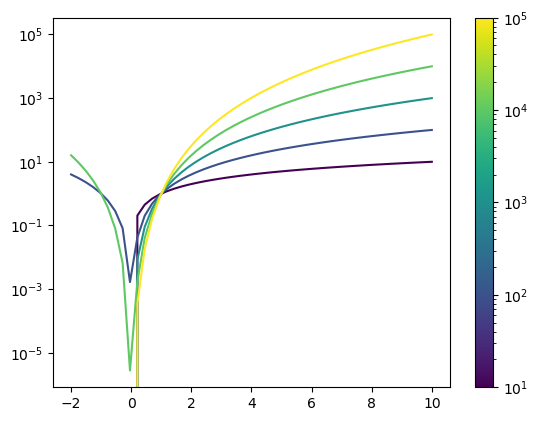

In [62]:
exps = [1, 2, 3, 4, 5]; x = np.linspace(-2, 10)
exps | cli.apply(lambda exp: [max(x**exp), x, x**exp]) | toCm(0, log=True) | ~cli.apply(lambda c,x,y: plt.plot(x,y,color=c)) | cli.deref()
plt.yscale("log")

In [50]:
#export
PyPDF2 = k1lib.dep("PyPDF2", url="https://pypdf2.readthedocs.io/")
pymupdf = k1lib.dep("pymupdf", url="https://pymupdf.readthedocs.io/")
class Pdf:
    def __init__(self, fn):
        self.fn = os.path.expanduser(fn); self._handle = None; self._open()
    def _open(self):
        if self._handle is not None: return
        self._handle = open(self.fn, 'rb')
        self._reader = PyPDF2.PdfReader(self._handle)
        self._npages = len(self._reader.pages);
    def __iter__(self): return (PdfPage(self, i) for i in range(len(self)))
    def __getitem__(self, s):
        if isinstance(s, slice): return [PdfPage(self, i) for i in range(len(self))[s]]
        else: return PdfPage(self, s)
    def __getstate__(self): d = dict(self.__dict__); d["_handle"] = None; d["_reader"] = None; return d
    def __setstate__(self, d): self.__dict__.update(d)
    def __repr__(self): return f"<Pdf #pages={len(self)} '{self.fn}'>"
    def __del__(self):
        if self._handle: self._handle.close()
    def __len__(self): return self._npages
class PdfPage:
    def __init__(self, pdf:Pdf, i:int):
        self.pdf = pdf; self.i = i; self._cached_fitz = None
    def __repr__(self): return f"<PdfPage page={self.i} #pages={len(self.pdf)} fn='{self.pdf.fn}'>"
    def _cat(self):
        self.pdf._open()
        with open(self.pdf.fn, 'rb') as o: return self.pdf._reader.pages[self.i].extract_text().split("\n")
    def _fitz(self):
        if self._cached_fitz is None: self._cached_fitz = pymupdf.open(self.pdf.fn)[self.i]
        return self._cached_fitz
    def blocks(self, heightFrac=0.01, group=False, ratio=False):
        """Grab text blocks. Returns blocks in reading order.
Example::

    page = "some_pdf_file.pdf" | toPdf() | item() # grabs first page
    page.blocks()           # returns [[[92.95, 187.05, 116.05, 199.84], "some text"], [...], ...]
    page.blocks(group=True) # returns [[[[92.95, 187.05, 116.05, 199.84], "some text"], [[x1, y1, x2, y2], "text on same row"]], [...], ...]
    page.blocks(ratio=True) # returns [[[0.1, 0.3, 0.2, 0.32], "some text"], [...], ...]

:param heightFrac: if 2 text blocks are too close together in y direction (delta height < heightFrac * document height),
    then group those together, sort by x, then joins. So the result goes from top left to bottom right
:param group: if True, returns blocks of rows instead of joining all of them together by default
:param ratio: if True, return coordinate ratios with width and height, instead of absolute pixels"""
        blocks = self._fitz().get_text("blocks") | cli.filt("x==0", 6) | cli.sort(1) | cli.apply(lambda row: row[:5]) | cli.deref()
        width, height = self._shape(); ratioF = (cli.apply(lambda x: x/width, [0, 2]) | cli.apply(lambda y: y/height, [1, 3])) if ratio else cli.iden()
        return blocks | cli.batchedTrigger(1, delta=height*heightFrac, adj=False) | cli.apply(cli.sort(0) | ratioF | cli.apply(lambda row: [row[:4], row[4]])) | (cli.iden() if group else cli.joinSt()) | cli.deref()
    def _toImg(self, **kwargs):
        k1lib.depCli("pdftoppm"); fn2 = b"" | cli.file(); fn = self.pdf.fn.replace("'", "\\'"); i = self.i
        None | cli.cmd(f"pdftoppm -f {i+1} -l {i+1} -jpeg '{fn}' {fn2} -singlefile") | cli.deref()
        im = f"{fn2}.jpg" | cli.toImg(); os.remove(f"{fn2}.jpg"); os.remove(fn2); return im
    def _shape(self, idx=None): d = (self._fitz().rect.width, self._fitz().rect.height); return d if idx is None else d[idx]
_pdf_initialized = [False]
def _pdf_init():
    if _pdf_initialized[0]: return
    _pdf_initialized[0] = True; k1lib.cli.init.addAtomic(Pdf); k1lib.cli.init.addAtomic(PdfPage)
class toPdf(BaseCli):
    blurb="Reads a pdf file to a managed object and can do lots of downstream tasks from there"
    def __init__(self):
        """Reads a pdf file. Can do lots of downstream tasks.
Example::

    pdf = "someFile.pdf" | toPdf()
    len(pdf)         # get number of pages
    pdf[2] | cat()   # get text content of 2nd (0-indexed) page
    pdf[2] | toImg() # converts 2nd page to an image
    pdf[2].blocks()  # grabs a list of text blocks, ordered top to bottom, like [[[x1, y1, x2, y2], "some text"], [...], ...]
"""
        _pdf_init()
    def __ror__(self, it) -> Pdf: return Pdf(it)

In [51]:
fn = "/home/kelvin/Downloads/spec docs/bmw i3 reports/Zone 9 IP & Interior Trim Report 6-8-17.pdf"
pdf = fn | toPdf()
assert len(pdf) == 4008
assert pdf[3] | cli.cat() | cli.shape() == (11, 84)
assert pdf[3] | cli.toImg() | cli.shape() == (1500, 1125)

In [52]:
#export
class toDist(BaseCli):
    blurb="Calculates the euclidean distance of the input points"
    def __init__(self, norm=2):
        """Calculates the euclidean distance of the input points.
Example::

    a = np.random.randn(3)
    b = np.random.randn(3)
    [a, b] | toDist() # returns distance between those 2 points

Essentially just ((a-b)**2).sum()**0.5. But I kept needing this over and
over again so gotta make it into a separate cli."""
        self.norm = norm
    def __ror__(self, it): a,b = it; return ((a-b)**self.norm).sum()**(1/self.norm)

In [53]:
a = np.random.randn(3)
b = np.random.randn(3)
[a, b] | toDist()

3.3194090220519543

In [54]:
#export
class toAngle(BaseCli):
    blurb="Calculates the angle between 2 vectors"
    def __init__(self, radians=True):
        """Calculates the angle between 2 vectors.
Example::

    a = np.random.randn(3)
    b = np.random.randn(3)
    [a, b] | toAngle() # returns angle between those 2 vectors
"""
        self.radians = radians; self.mult = 1 if radians else 180/math.pi
    def __ror__(self, it):
        a,b = it; la = (a**2).sum()**0.5; lb = (b**2).sum()**0.5
        return math.acos(a@b/la/lb)*self.mult

In [55]:
[a, b] | toAngle()

2.145539920831574

In [56]:
#export
class idxsToNdArray(BaseCli):
    blurb="Converts indices (aka point cloud) to numpy array"
    def __init__(self, ds:"tuple[int]"=None, n:int=None):
        """Converts indices (aka point cloud) to numpy array.
Example::

    [[1,2], [2,3]]         | idxsToNdArray()         # returns np.array([[0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    [[1,2], [2,3]]         | idxsToNdArray(n=2)      # returns np.array([[0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    [[1,2], [2,3]]         | idxsToNdArray(ds=[3,4]) # returns np.array([[0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

So, the standard use case is that you have a point cloud (points [1,2] and [2,3]) and you want
to get the dense array with those points filled in. Then you can do it with this function. Notice
how in all 3 examples, the points are marked with a 1. You can specify either the dense array's
shape using parameter ".ds", or just the number of dimensions with parameter ".n". If you specify
neither then it will auto figure that out, but the final shape might not be what you wanted.

Let's see some other use cases:

    [[1,2,3], [2,3,4]]     | idxsToNdArray() | shape() # returns (3, 4, 5)
    [[1,2,3], [2,3,4]]     | idxsToNdArray(n=2)        # returns np.array([[0, 0, 0, 0], [0, 0, 3, 0], [0, 0, 0, 4]])
    [[1,2,3], [2,3,4]]     | idxsToNdArray(n=1)        # returns np.array([[0, 0], [2, 3], [3, 4]])
    [[1,2,3,4], [2,3,4,5]] | idxsToNdArray(n=2)        # returns np.array([[[0, 0], [0, 0], [0, 0], [0, 0]], [[0, 0], [0, 0], [3, 4], [0, 0]], [[0, 0], [0, 0], [0, 0], [4, 5]]])

In the first example, if you don't specify the dimensions, it will return a 3d array, and
the selected points will have the value 1. But if you insist that it should have 2 dimensions
only, and the remaining columns should be the selected points' values, then you can either limit
.n, or specify the shape .ds but only has length of 2. Notice how the second example got filled
in by values 3 and 4 and not 1.

:param ds: dimensions
:param n: number of dimensions"""
        self.ds = ds; self.n = n
        if ds is not None and n is not None and len(ds) != n: raise Exception("Can specify either .ds or .n only. .n will be inferred from .ds")
    def __ror__(self, it):
        n = self.n; ds = self.ds; arr = None
        it = init.dfGuard(it) | cli.deref(2) | cli.toNdArray()
        if len(it.shape) != 2: raise Exception("Input have to be a 2d array")
        if n is None and ds is None: n = len(it[0]); F = 1; ds = it.T | cli.toMax().all() | cli.op().astype(int)+1
        elif n is not None: ds = it[:,:n].T | cli.toMax().all() | cli.op().astype(int)+1; F = len(it[0]) - n
        elif ds is not None: n = len(ds); F = len(it[0]) - n
        if len(it[0]) == n: it = np.hstack([it, np.ones(it.shape[0])[:,None]])
        sel = tuple(it[:,:n].T.astype(int).tolist())
        if F > 1: arr = np.zeros((*ds,F)); arr[sel] = it[:,n:]
        else: arr = np.zeros(ds); arr[sel] = it[:,n]
        return arr

In [57]:
assert ([[1,2,3], [2,3,4]] | idxsToNdArray(n=2) == np.array([[0., 0., 0., 0.], [0., 0., 3., 0.], [0., 0., 0., 4.]])).all()
assert ([[1,2], [2,3]] | idxsToNdArray() == np.array([[0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])).all()
assert ([[1,2], [2,3]] | idxsToNdArray(n=2) == np.array([[0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])).all()
assert ([[1,2], [2,3]] | idxsToNdArray(ds=[3,4]) == np.array([[0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])).all()
assert ([[1,2,3], [2,3,4]] | idxsToNdArray(n=1) == np.array([[0, 0], [2, 3], [3, 4]])).all()
assert ([[1,2,3,4], [2,3,4,5]] | idxsToNdArray(n=2) == np.array([[[0, 0], [0, 0], [0, 0], [0, 0]], [[0, 0], [0, 0], [3, 4], [0, 0]], [[0, 0], [0, 0], [0, 0], [4, 5]]])).all()
assert [[1,2,3], [2,3,4]]     | idxsToNdArray() | cli.shape() == (3, 4, 5)

In [58]:
#export
_toFileType_tmpFile = [None]
class toFileType(BaseCli):
    blurb="Grab file type of a file or file contents (bytes)"
    def __init__(self):
        """Grab file type of a file or file contents.
Example::

    # returns "PNG image data, 1024 x 1365, 8-bit/color RGBA, non-interlaced"
    "some_image.png" | toFileType()
    # returns "JPEG image data, JFIF standard 1.01, aspect ratio, density 1x1, segment length 16, baseline, precision 8, 1024x1365, components 3"
    "some_image.png" | toImg() | toBytes() | toFileType()

This does take quite a while to execute, up to 42ms/file, so if you're doing it a lot, would
suggest you use :class:`~k1lib.cli.modifier.applyMp` or something like that. Internally, this
will call the command line program ``file`` and returns its results, so this is just a convenience
cli."""
        if _toFileType_tmpFile[0] is None: _toFileType_tmpFile[0] = b"" | cli.file()
        self.autoInc = k1lib.AutoIncrement()
    def __ror__(self, it):
        if isinstance(it, str):
            fn = os.path.expanduser(it); it = fn.replace("'", """'"'"'""")
            res = None | cli.cmd(f"file '{it}'") | cli.item()
        elif isinstance(it, bytes):
            fn = f"{_toFileType_tmpFile[0]}_{os.getpid()}_{self.autoInc()}"
            it | cli.file(fn); res = None | cli.cmd(f"file {fn}") | cli.item(); os.remove(fn)
        else: raise Exception("toFileType() only accepts either path (string) or file content (bytes)")
        return res.replace(f"{fn}: ", "")

In [60]:
assert "test/crew dragon.jpg" | toFileType() == 'JPEG image data, baseline, precision 8, 1280x853, components 3'

In [3]:
#export
qrcode = k1lib.dep("qrcode", url="https://github.com/lincolnloop/python-qrcode")
class toQr(BaseCli):
    def __init__(self):
        """Creates a QR code PIL image encoding the specified text.
Example::

    "abc" | toQr()
"""
        pass
    def __ror__(self, it):
        if not isinstance(it, str): it = f"{it}"
        return qrcode.make(it).get_image()

In [8]:
assert isinstance("abc" | toQr(), PIL.Image.Image)

In [ ]:
#export
openpyxl = k1lib.dep("openpyxl", url="https://openpyxl.readthedocs.io/en/stable/")
class ExcelFile:
    def __init__(self, fn): self.fn = fn; self.wb = openpyxl.load_workbook(fn)
    @functools.lru_cache
    def _ls(self): return [ExcelSheet(self.wb, self.fn, name) for name in self.wb.sheetnames]
    def __getitem__(self, key):
        if key not in self.wb.sheetnames: raise Exception(f"Sheet {key} doesn't exist")
        return ExcelSheet(self.wb, self.fn, key)
    def __repr__(self): return f"<ExcelFile fn='{self.fn}'>"
class ExcelSheet:
    def __init__(self, wb, fn, name): self.wb = wb; self.fn = fn; self.name = name; self.ref = wb[name]
    def _cat(self): return [[x.value for x in row] for row in self.ref]
    def __repr__(self): return f"<ExcelSheet fn='{self.fn}' name='{self.name}'>"
@functools.lru_cache
def num2ExcelCol(x):
    s = ""
    while x >= 0: s = chr(ord("A") + (x % 26)) + s; x = x // 26 - 1
    return s
class toExcel(BaseCli):
    def __init__(self):
        """2 modes:

1) Reads an excel file and returns an :class:`ExcelFile` object that can do many things.

This mode is activated when the input is a string, which it is interpreted as a file name.
Example::

    workbook = "somefile.xlsx" | toExcel() # reads the file
    worksheet = workbook | ls()            # lists out all sheets within the workbook
    worksheet | cat()                      # grabs all cells' values, returns List[List[Any]]

2) Converts a python table to excel sheet in bytes.
Example::

    # returns bytes of the excel file, merging A1:B1, with all correct column widths
    [["A", None, "B"], [1, 2, 3]] | toExcel()
    # saves to the specified file
    [["A", None, "B"], [1, 2, 3]] | toExcel() | file("somefile.xlsx")
"""
        pass
    def __ror__(self, it):
        if isinstance(it, str): return ExcelFile(it)
        data = it; wb = openpyxl.Workbook(); ws = wb.active
        for nR, row in enumerate(data):
            d = []; l = []
            for nC, e in row | cli.insId():
                if e is not None and len(l) == 0: l.append([nC, e])
                elif e is not None and len(l) > 0: d.append(l); l = [[nC, e]]
                elif e is None: l.append([nC, e])
            if len(l) > 0: d.append(l)
            for group in d:
                sC1 = num2ExcelCol(group[0][0]); sC2 = num2ExcelCol(group[-1][0])
                if len(group) > 1: ws.merge_cells(f"{sC1}{nR+1}:{sC2}{nR+1}")
                ws[f"{sC1}{nR+1}"] = group[0][1]
        colWidths = data | cli.aS(lambda x: len(f'{x or ""}')).all(2) | cli.T() | cli.apply(cli.toMax()) | cli.deref()
        for i, x in enumerate(colWidths): ws.column_dimensions[num2ExcelCol(i)].width = 5+x
        fn = b"" | cli.file(); wb.save(fn); contents = cli.cat(fn, False); os.remove(fn); return contents

In [3]:
#export
class toMdTable():
    def __init__(self):
        """Converts incoming table to a nice markdown table.
Example::

    ["ABC", [1,2,3], "456", "789"] | toMdTable()

That returns::

    ['| A  | B  | C  |',
     '| -- | -- | -- |',
     '| 1  | 2  | 3  |',
     '| 4  | 5  | 6  |',
     '| 7  | 8  | 9  |']

Honestly this is just a convenience function, as you can typically just do ``table | display()``
and that'd be enough in a jupyter environment. But I was trying to use obsidian and want to
generate a table that obsidian can understand"""
        pass
    def __ror__(self, it):
        data = it | cli.deref(2); data = [*data[:1], [], *data[1:]] | cli.T.wrap(cli.iden(), fill="") | cli.pretty("|   ") | cli.apply(lambda x: f"|   {x}|".replace("   |","  |").replace("|   ","| ")) | cli.deref()
        if len(data)>1: data[1] = data[1].replace(*" -").replace("|-","| ").replace("-|"," |") | cli.deref()
        return data

In [5]:
assert ["ABC", [1,2,3], "456", "789"] | toMdTable() == ['| A  | B  | C  |', '| -- | -- | -- |', '| 1  | 2  | 3  |', '| 4  | 5  | 6  |', '| 7  | 8  | 9  |']

In [23]:
!../../export.py cli/conv --upload=True

./export started up - /home/quang/miniforge3/bin/python
----- exportAll
16373   0   61%   
10613   1   39%   
Found existing installation: k1lib 1.7.3
Uninstalling k1lib-1.7.3:
  Successfully uninstalled k1lib-1.7.3
Looking in indexes: https://pypi.org/simple, http://10.104.0.3:3141/
Processing /home/quang/k1lib
  Preparing metadata (setup.py) ... done
  Created wheel for k1lib: filename=k1lib-1.7.3-py3-none-any.whl size=5114034 sha256=53a02e76efb2a5bea0899f6e00d77a58e52e9b39b53c8775f38b9bfcaec0febb
  Stored in directory: /tmp/pip-ephem-wheel-cache-h22jxaz4/wheels/b5/32/67/e20c84dce16d707fb881c12d405f70adfaa36fe7dae9021380
Successfully built k1lib


In [29]:
!../../export.py cli/conv

./export started up - /home/quang/miniforge3/bin/python
----- exportAll
16692   0   60%   
11040   1   40%   
installing...
Found existing installation: k1lib 1.8
Uninstalling k1lib-1.8:
  Successfully uninstalled k1lib-1.8
DEPRECATION: Loading egg at /home/quang/miniforge3/lib/python3.12/site-packages/aigu-0.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Looking in indexes: https://pypi.org/simple, http://10.104.0.3:3141/
Processing /home/quang/k1lib
  Preparing metadata (setup.py) ... done
  Created wheel for k1lib: filename=k1lib-1.8-py3-none-any.whl size=5132072 sha256=95b74791affa7980d3f0f35f7de31a677512039aa943efc22b1cb8635ef9ca2d
  Stored in directory: /tmp/pip-ephem-wheel-cache-ihox2krk/wheels/b5/32/67/e20c84dce16d707fb881c12d405f70adfaa36fe7dae9021380
Successfully built k1lib
installed


In [14]:
!../../export.py cli/conv --bootstrap=True

./export started up - /home/quang/miniforge3/bin/python
----- bootstrapping
Current dir: /home/quang/k1lib, /home/quang/k1lib/k1lib/cli/../../export.py
Found existing installation: k1lib 1.7.1
Uninstalling k1lib-1.7.1:
  Successfully uninstalled k1lib-1.7.1
DEPRECATION: Loading egg at /home/quang/miniforge3/lib/python3.12/site-packages/aigu-0.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Looking in indexes: https://pypi.org/simple, http://10.104.0.3:3141/
Processing /home/quang/k1lib
  Preparing metadata (setup.py) ... done
  Created wheel for k1lib: filename=k1lib-1.7.1-py3-none-any.whl size=5105928 sha256=73e26998c6599ab1f6d8f988527563e1a03306772fdf24bbed439f3650f8ff43
  Stored in directory: /tmp/pip-ephem-wheel-cache-7gj4uxnk/wheels/b5/32/67/e20c84dce16d707fb881c12d405f70adfaa36fe7dae9021380
Successfully built k1lib
